# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [2]:
%load_ext autoreload
%autoreload 2

In [300]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import seaborn as sns
import colorcet as cc
import gc
from utils.memory_usage import see_memory_usage

from utils.clustering_eval_utils import evaluate_model
from utils.clustering import *
from utils.feature_processing import *

DATA_DIR = './data/Lernnavi' # You many change the directory

# Your code goes here

## Task 0: Research Question

**Research question:**
What distinct learning behaviors exist based on platform interactions and patterns over time? Can we categorize students into different learner types?

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

# 1. Load Data


In [4]:
users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [5]:
users.columns

Index(['user_id', 'gender', 'canton', 'class_level', 'study', 'class_id'], dtype='object')

In [6]:
events.columns

Index(['event_id', 'user_id', 'event_date', 'category', 'action', 'event_type',
       'transaction_token', 'tracking_data', 'session_id', 'topic_id',
       'session_closed', 'session_type', 'session_accepted'],
      dtype='object')

In [7]:
transactions.columns

Index(['transaction_id', 'transaction_token', 'user_id', 'document_id',
       'document_version', 'evaluation', 'input', 'start_time', 'commit_time',
       'user_agent', 'solution', 'type', 'session_id', 'topic_id',
       'session_closed', 'session_type', 'session_accepted', 'challenge',
       'challenge_id', 'challenge_order', 'challenge_name'],
      dtype='object')

# 2. Feature Engineering


## 2.1 Session-based Features
- Standard deviation of session duration
- Median session duration

### Step 1 — Session-level features

In [8]:
# Example for session features
df_events = events.copy()
df_events['event_date'] = pd.to_datetime(df_events['event_date'])
#date


In [9]:
session_features = df_events.groupby(['user_id', 'session_id']).agg(
    num_events_in_session=('event_date', 'count'),
    session_duration_min=('event_date', lambda x: (x.max() - x.min()).total_seconds() / 60),
    session_closed=('session_closed', 'max'),  # should be 0 or 1
    session_accepted=('session_accepted', 'max'),
    unique_topics_in_session=('topic_id', 'nunique')
).reset_index()


### Step 2 — User-level aggregations from session_features

In [10]:
user_session_features = session_features.groupby('user_id').agg(
    total_sessions=('session_id', 'nunique'),
    total_num_events=('num_events_in_session', 'sum'),
    avg_session_duration_min=('session_duration_min', 'mean'),
    median_session_duration_min=('session_duration_min', 'median'),
    std_session_duration_min=('session_duration_min', 'std'),
    max_session_duration_min=('session_duration_min', 'max'),
    min_session_duration_min=('session_duration_min', 'min'),
    avg_num_events_per_session=('num_events_in_session', 'mean'),
    avg_unique_topics_per_session=('unique_topics_in_session', 'mean'),
    pct_sessions_closed=('session_closed', 'mean'),
    pct_sessions_accepted=('session_accepted', 'mean')
).reset_index()


### Step 3 — Time between sessions


In [11]:
# Sort by user and session start
session_features = session_features.sort_values(['user_id', 'session_id'])  # we need to know time order
df_events['event_date'] = pd.to_datetime(df_events['event_date'])

# Calculate session start date
session_starts = df_events.groupby(['user_id', 'session_id'])['event_date'].min().reset_index()
session_starts = session_starts.sort_values(['user_id', 'event_date'])

# Calculate time differences
session_starts['time_since_last_session_hr'] = session_starts.groupby('user_id')['event_date'].diff().dt.total_seconds() / 3600

# Aggregate per user
temporal_features = session_starts.groupby('user_id').agg(
    avg_time_between_sessions_hr=('time_since_last_session_hr', 'mean'),
    std_time_between_sessions_hr=('time_since_last_session_hr', 'std'),
    max_inactivity_period_hr=('time_since_last_session_hr', 'max')
).reset_index()


### Step 4 — Active days & average sessions per active day

In [12]:
df_events['event_date_only'] = df_events['event_date'].dt.date
days_active = df_events.groupby('user_id')['event_date_only'].nunique().reset_index(name='days_active')

# Sessions per day
sessions_per_day = session_starts.copy()
sessions_per_day['session_day'] = sessions_per_day['event_date'].dt.date
sessions_per_day = sessions_per_day.groupby(['user_id', 'session_day']).size().reset_index(name='sessions_per_day')
avg_sessions_per_active_day = sessions_per_day.groupby('user_id')['sessions_per_day'].mean().reset_index(name='avg_sessions_per_active_day')


### Step 5 — Final merge: Session Features

In [13]:
final_session_features = user_session_features \
    .merge(temporal_features, on='user_id', how='left') \
    .merge(days_active, on='user_id', how='left') \
    .merge(avg_sessions_per_active_day, on='user_id', how='left')


In [14]:
final_session_features

user_id  total_sessions  total_num_events  avg_session_duration_min  \
0       387604              61              1105              12963.096278   
1       387605              67               742              29595.661530   
2       387608              31               469              11904.947317   
3       387613               4                31                  1.019733   
4       387615               2                48                  9.675450   
...        ...             ...               ...                       ...   
19625   431999               4                21                  4.107954   
19626   432001               1                 7                 13.184783   
19627   432014               2                25                  7.975892   
19628   432016               2                 4                  0.564775   
19629   432020               3                57                  3.887733   

       median_session_duration_min  std_session_duration_min  \
0                         1.331083              64843.133625   
1                         3.315933              98793.615011   
2                         3.627667              40661.940478   
3                         0.923208                  0.581060   
4                         9.675450                  0.642996   
...                            ...                       ...   
19625                     2.271158                  4.881144   
19626                    13.184783                       NaN   
19627                     7.975892                  4.141560   
19628                     0.564775                  0.644304   
19629                     4.582450                  3.591132   

       max_session_duration_min  min_session_duration_min  \
0                 492921.146800                  0.000000   
1                 531286.253133                  0.000000   
2                 217246.262683                  0.000000   
3                      1.766600                  0.465917   
4                     10.130117                  9.220783   
...                         ...                       ...   
19625                 11.189883                  0.699617   
19626                 13.184783                 13.184783   
19627                 10.904417                  5.047367   
19628                  1.020367                  0.109183   
19629                  7.080750                  0.000000   

       avg_num_events_per_session  avg_unique_topics_per_session  \
0                       18.114754                       0.918033   
1                       11.074627                       0.955224   
2                       15.129032                       0.548387   
3                        7.750000                       1.000000   
4                       24.000000                       1.000000   
...                           ...                            ...   
19625                    5.250000                       1.000000   
19626                    7.000000                       1.000000   
19627                   12.500000                       1.000000   
19628                    2.000000                       1.000000   
19629                   19.000000                       1.000000   

       pct_sessions_closed  pct_sessions_accepted  \
0                 0.982143               0.826087   
1                 0.984375               1.000000   
2                 1.000000               1.000000   
3                 0.750000               1.000000   
4                 1.000000               1.000000   
...                    ...                    ...   
19625             0.750000                    NaN   
19626             1.000000                    NaN   
19627             1.000000               1.000000   
19628             0.500000                    NaN   
19629             0.666667               1.000000   

       avg_time_between_sessions_hr  std_time_between_sessions_hr  \
0                        229.595889          

In [15]:
# Step 1: Fill standard deviation and time-based NaNs with 0
std_cols = ['std_time_between_sessions_hr', 'std_session_duration_min']
time_cols = ['avg_time_between_sessions_hr', 'max_inactivity_period_hr']

final_session_features[std_cols + time_cols] = final_session_features[std_cols + time_cols].fillna(0)

# Step 2: Fill acceptance ratio with 0 (means no acceptance events)
final_session_features['pct_sessions_accepted'] = final_session_features['pct_sessions_accepted'].fillna(0)

# Step 3: Fill pct_sessions_closed with median (only 3 missing values)
final_session_features['pct_sessions_closed'] = final_session_features['pct_sessions_closed'].fillna(final_session_features['pct_sessions_closed'].median())

# Step 4: Double check
print(final_session_features.isnull().sum())


user_id                          0
total_sessions                   0
total_num_events                 0
avg_session_duration_min         0
median_session_duration_min      0
std_session_duration_min         0
max_session_duration_min         0
min_session_duration_min         0
avg_num_events_per_session       0
avg_unique_topics_per_session    0
pct_sessions_closed              0
pct_sessions_accepted            0
avg_time_between_sessions_hr     0
std_time_between_sessions_hr     0
max_inactivity_period_hr         0
days_active                      0
avg_sessions_per_active_day      0
dtype: int64


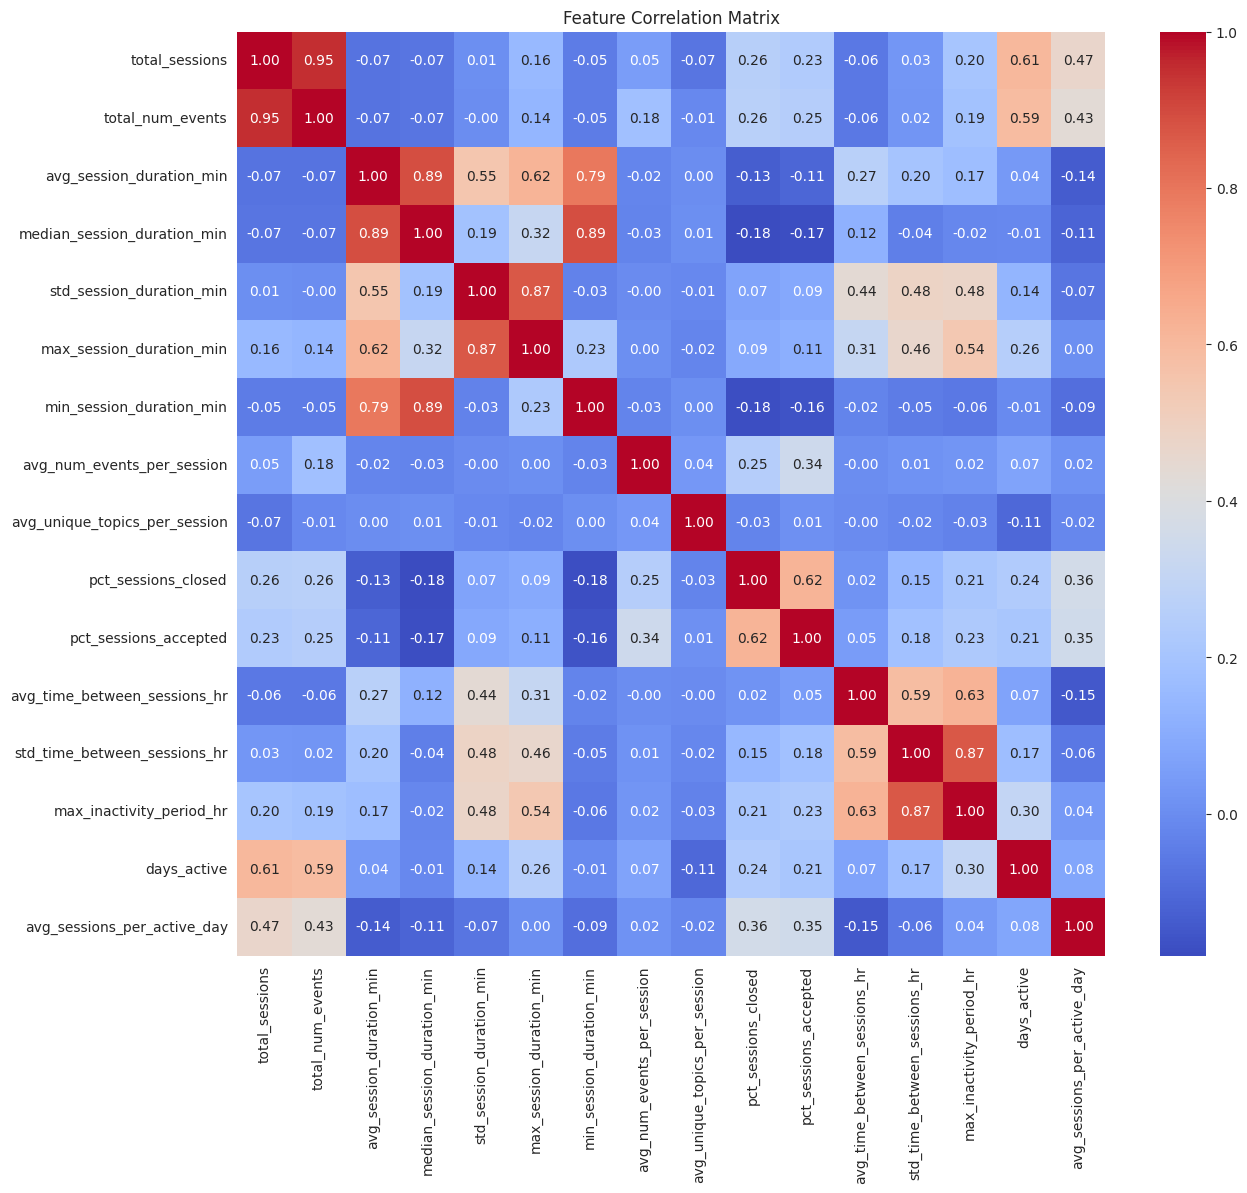

In [16]:
# Drop user_id (keep it somewhere safe if you need to track students later)
X = final_session_features.drop(columns=['user_id'])

import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(14,12))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()



## Correlation Analysis of Session-Based Features

To ensure we avoid redundancy in the feature space and maintain meaningful dimensions for clustering, we performed a correlation analysis on the session-based features.

Key observations:
- **total_sessions** and **total_num_events** were highly correlated (0.95). We decided to keep **total_sessions** (more interpretable) and drop **total_num_events**.
- **median_session_duration_min** and **max_session_duration_min** were highly correlated (0.89). We kept **median_session_duration_min** (more robust to outliers).
- **avg_time_between_sessions_hr** and **max_inactivity_period_hr** were also highly correlated (0.86). We chose to retain **avg_time_between_sessions_hr** to better capture regularity.

Other features showed moderate or low correlation and were retained to preserve richness in behavioral descriptions.

After pruning, we kept a diverse, minimally redundant set of features. Scaling will be applied next before moving to dimensionality reduction and clustering.


In [17]:
# 1. Drop user_id to work only with features
X = final_session_features.drop(columns=['user_id'])

# 2. Drop highly correlated features
X = X.drop(columns=[
    'total_num_events',          # because of high correlation with total_sessions
    'max_session_duration_min',  # because of high correlation with median session duration
    'max_inactivity_period_hr'    # because of high correlation with avg_time_between_sessions
])

# Optional: keep or drop std_session_duration_min if we want a stricter pruning (we keep it for now)

# 3. Attach back user_id if needed (optional, useful to track students after clustering)
final_session_features_clean = pd.concat([final_session_features[['user_id']], X], axis=1)

# 4. Quick check
final_session_features_clean.head()


user_id  total_sessions  avg_session_duration_min  \
0   387604              61              12963.096278   
1   387605              67              29595.661530   
2   387608              31              11904.947317   
3   387613               4                  1.019733   
4   387615               2                  9.675450   

   median_session_duration_min  std_session_duration_min  \
0                     1.331083              64843.133625   
1                     3.315933              98793.615011   
2                     3.627667              40661.940478   
3                     0.923208                  0.581060   
4                     9.675450                  0.642996   

   min_session_duration_min  avg_num_events_per_session  \
0                  0.000000                   18.114754   
1                  0.000000                   11.074627   
2                  0.000000                   15.129032   
3                  0.465917                    7.750000   
4                  9.220783                   24.000000   

   avg_unique_topics_per_session  pct_sessions_closed  pct_sessions_accepted  \
0                       0.918033             0.982143               0.826087   
1                       0.955224             0.984375               1.000000   
2                       0.548387             1.000000               1.000000   
3                       1.000000             0.750000               1.000000   
4                       1.000000             1.000000               1.000000   

   avg_time_between_sessions_hr  std_time_between_sessions_hr  days_active  \
0                    229.595889                    425.555724          100   
1                    187.273808                    464.944778           54   
2                    407.203174                    787.446374           87   
3                    439.497068                    548.218223            5   
4                      0.172846                      0.000000           12   

   avg_sessions_per_active_day  
0                     2.103448  
1                     2.913043  
2                     2.214286  
3                     1.333333  
4                     2.000000

In [18]:
final_session_features.columns

Index(['user_id', 'total_sessions', 'total_num_events',
       'avg_session_duration_min', 'median_session_duration_min',
       'std_session_duration_min', 'max_session_duration_min',
       'min_session_duration_min', 'avg_num_events_per_session',
       'avg_unique_topics_per_session', 'pct_sessions_closed',
       'pct_sessions_accepted', 'avg_time_between_sessions_hr',
       'std_time_between_sessions_hr', 'max_inactivity_period_hr',
       'days_active', 'avg_sessions_per_active_day'],
      dtype='object')

## 2.2 Performance-based Features
- Progression trend (e.g., did scores improve?)
- Ratio of correct/incorrect responses

### Step 1 — Accuracy by Question Type

In [19]:
df_transactions = transactions.copy()

In [20]:
# 1. Check if evaluation exists
print('evaluation' in df_transactions.columns)

# 2. Check if type exists
print('type' in df_transactions.columns)

# 3. See a sample of your transactions
df_transactions.head()

# 4. Check if evaluation values are NaN
print(df_transactions['evaluation'].isnull().mean())

# 5. Check if type values are NaN
print(df_transactions['type'].isnull().mean())


True
True
0.34371655067386997
0.34347062127387684


## Note on Accuracy by Question Type

Initially, we intended to compute user accuracy per question type based on the `evaluation` field from the transactions table.

However, upon inspection, we found that the `evaluation` column is entirely missing (100% NaN) in the provided dataset.  
As a result, it is not possible to derive meaningful accuracy measures for users.

Therefore, we decided to exclude the "Accuracy by Question Type" feature from our performance feature set and focus on alternative behavioral indicators, such as response times, task diversity, and topic diversity.


### Step 2 — Median Response Time by Question Type

In [21]:
# Compute response time
df_transactions['start_time'] = pd.to_datetime(df_transactions['start_time'])
df_transactions['commit_time'] = pd.to_datetime(df_transactions['commit_time'])

df_transactions['response_time_sec'] = (df_transactions['commit_time'] - df_transactions['start_time']).dt.total_seconds()

# Median response time per user and question type
median_response_time = df_transactions.groupby(['user_id', 'type'])['response_time_sec'].median().unstack()

# Check
median_response_time.head()


type     CLOZE_MATH  CLOZE_TEXT  CLOZE_TEXT_DROPDOWN  DND_GROUP  DND_IN_TEXT  \
user_id                                                                        
387604          NaN     19.5185              20.7750    11.2100       19.081   
387605       32.646     24.7470              15.7585    57.8570       27.930   
387608       27.009         NaN              13.3600    55.5665          NaN   
387613          NaN         NaN                  NaN        NaN          NaN   
387615          NaN         NaN              51.6140        NaN          NaN   

type     DND_ORDER  DND_PAIRS  FIX_TEXT  GRAPH_CLICK_POINTS  \
user_id                                                       
387604      27.560    18.8735   19.9335                 NaN   
387605      19.688    31.7535   35.0460             74.3065   
387608      30.129    29.1065       NaN              8.3795   
387613         NaN        NaN       NaN                 NaN   
387615         NaN        NaN       NaN                 NaN   

type     GRAPH_SELECT_SHAPE  GRAPH_SOLUTION_FIELD  HIGHLIGHT  \
user_id                                                        
387604                  NaN                   NaN     36.010   
387605               11.921              107.6295     95.275   
387608               14.589                   NaN        NaN   
387613                  NaN                   NaN        NaN   
387615                  NaN                   NaN        NaN   

type     MATH_STEP_BY_STEP  MULTIPLE_CHOICE  MULTI_COLOR_HIGHLIGHT  OPEN_TASK  \
user_id                                                                         
387604                 NaN          14.7965                 30.144     26.138   
387605              69.994          15.1780                 44.618     18.241   
387608              61.063          19.5045                    NaN        NaN   
387613              41.331              NaN                    NaN        NaN   
387615                 NaN          21.7200                    NaN        NaN   

type     SEPARATE_TEXT  SOLUTION_FIELD  
user_id                                 
387604         15.2045             NaN  
387605          8.1910         32.6680  
387608             NaN         19.0135  
387613             NaN         20.9145  
387615         14.6040             NaN

In [22]:
# Drop users with all NaNs in response time
median_response_time_clean = median_response_time.dropna(how='all')
median_response_time_clean = median_response_time_clean.fillna(0)

# Check
print(f"Remaining users: {len(median_response_time_clean)} / {len(median_response_time)}")
median_response_time_clean.head()


Remaining users: 21434 / 21434


type     CLOZE_MATH  CLOZE_TEXT  CLOZE_TEXT_DROPDOWN  DND_GROUP  DND_IN_TEXT  \
user_id                                                                        
387604        0.000     19.5185              20.7750    11.2100       19.081   
387605       32.646     24.7470              15.7585    57.8570       27.930   
387608       27.009      0.0000              13.3600    55.5665        0.000   
387613        0.000      0.0000               0.0000     0.0000        0.000   
387615        0.000      0.0000              51.6140     0.0000        0.000   

type     DND_ORDER  DND_PAIRS  FIX_TEXT  GRAPH_CLICK_POINTS  \
user_id                                                       
387604      27.560    18.8735   19.9335              0.0000   
387605      19.688    31.7535   35.0460             74.3065   
387608      30.129    29.1065    0.0000              8.3795   
387613       0.000     0.0000    0.0000              0.0000   
387615       0.000     0.0000    0.0000              0.0000   

type     GRAPH_SELECT_SHAPE  GRAPH_SOLUTION_FIELD  HIGHLIGHT  \
user_id                                                        
387604                0.000                0.0000     36.010   
387605               11.921              107.6295     95.275   
387608               14.589                0.0000      0.000   
387613                0.000                0.0000      0.000   
387615                0.000                0.0000      0.000   

type     MATH_STEP_BY_STEP  MULTIPLE_CHOICE  MULTI_COLOR_HIGHLIGHT  OPEN_TASK  \
user_id                                                                         
387604               0.000          14.7965                 30.144     26.138   
387605              69.994          15.1780                 44.618     18.241   
387608              61.063          19.5045                  0.000      0.000   
387613              41.331           0.0000                  0.000      0.000   
387615               0.000          21.7200                  0.000      0.000   

type     SEPARATE_TEXT  SOLUTION_FIELD  
user_id                                 
387604         15.2045          0.0000  
387605          8.1910         32.6680  
387608          0.0000         19.0135  
387613          0.0000         20.9145  
387615         14.6040          0.0000

- Students who did not attempt any tasks were removed from the dataset.

- For students who missed some task types, missing median response times were filled with 0, 
meaning "no recorded interaction" for that task type.

### Step 3 — Task Diversity

In [23]:
# Step 3: Task diversity
task_diversity = df_transactions.groupby('user_id')['type'].nunique().reset_index()
task_diversity.columns = ['user_id', 'task_type_diversity']

# Check
task_diversity.head()


user_id  task_type_diversity
0   387604                   12
1   387605                   18
2   387608                   10
3   387613                    2
4   387615                    3

### Step 4 — Preferred Task Type

In [24]:
# Step 3B: Preferred task type
def safe_mode(series):
    mode = series.mode()
    return mode.iloc[0] if not mode.empty else np.nan

preferred_task_type = df_transactions.groupby('user_id')['type'].agg(safe_mode).reset_index()
preferred_task_type.columns = ['user_id', 'preferred_task_type']

# Check
preferred_task_type.head()


user_id  preferred_task_type
0   387604  CLOZE_TEXT_DROPDOWN
1   387605       SOLUTION_FIELD
2   387608      MULTIPLE_CHOICE
3   387613    MATH_STEP_BY_STEP
4   387615      MULTIPLE_CHOICE

### Step 5 — Topic Diversity

In [25]:
# Step 3C: Topic diversity
topic_diversity = df_events.groupby('user_id')['topic_id'].nunique().reset_index()
topic_diversity.columns = ['user_id', 'topic_diversity']

# Check
topic_diversity.head()


user_id  topic_diversity
0   387604               14
1   387605               27
2   387608               12
3   387613                4
4   387615                1

### Step 6 - Clean merging of all performance features

In [26]:
# --- 1. Clean median_response_time ---
# Drop users with all NaN
median_response_time_clean = median_response_time.dropna(how='all')

# Fill missing response times with 0
median_response_time_clean = median_response_time_clean.fillna(0)

# Ensure user_id is a column
median_response_time_clean['user_id'] = median_response_time_clean.index
median_response_time_clean = median_response_time_clean.reset_index(drop=True)

# --- 2. Merge all performance features ---
performance_features = median_response_time_clean.merge(task_diversity, on='user_id', how='left')
performance_features = performance_features.merge(preferred_task_type, on='user_id', how='left')
performance_features = performance_features.merge(topic_diversity, on='user_id', how='left')

# --- 3. Check the result ---
print(f"Shape of performance_features: {performance_features.shape}")
performance_features.head()


Shape of performance_features: (21434, 22)


CLOZE_MATH  CLOZE_TEXT  CLOZE_TEXT_DROPDOWN  DND_GROUP  DND_IN_TEXT  \
0       0.000     19.5185              20.7750    11.2100       19.081   
1      32.646     24.7470              15.7585    57.8570       27.930   
2      27.009      0.0000              13.3600    55.5665        0.000   
3       0.000      0.0000               0.0000     0.0000        0.000   
4       0.000      0.0000              51.6140     0.0000        0.000   

   DND_ORDER  DND_PAIRS  FIX_TEXT  GRAPH_CLICK_POINTS  GRAPH_SELECT_SHAPE  \
0     27.560    18.8735   19.9335              0.0000               0.000   
1     19.688    31.7535   35.0460             74.3065              11.921   
2     30.129    29.1065    0.0000              8.3795              14.589   
3      0.000     0.0000    0.0000              0.0000               0.000   
4      0.000     0.0000    0.0000              0.0000               0.000   

   ...  MATH_STEP_BY_STEP  MULTIPLE_CHOICE  MULTI_COLOR_HIGHLIGHT  OPEN_TASK  \
0  ...              0.000          14.7965                 30.144     26.138   
1  ...             69.994          15.1780                 44.618     18.241   
2  ...             61.063          19.5045                  0.000      0.000   
3  ...             41.331           0.0000                  0.000      0.000   
4  ...              0.000          21.7200                  0.000      0.000   

   SEPARATE_TEXT  SOLUTION_FIELD  user_id  task_type_diversity  \
0        15.2045          0.0000   387604                   12   
1         8.1910         32.6680   387605                   18   
2         0.0000         19.0135   387608                   10   
3         0.0000         20.9145   387613                    2   
4        14.6040          0.0000   387615                    3   

   preferred_task_type  topic_diversity  
0  CLOZE_TEXT_DROPDOWN               14  
1       SOLUTION_FIELD               27  
2      MULTIPLE_CHOICE               12  
3    MATH_STEP_BY_STEP                4  
4      MULTIPLE_CHOICE                1  

[5 rows x 22 columns]

## Performance-Based Features Construction

We selected the following performance features:
- Median response time per question type
- Task type diversity (number of task types attempted)
- Preferred task type (most frequent task type)
- Topic diversity (number of unique topics worked on)

The features were merged into a single table for further cleaning and analysis.


In [27]:
# Check missing values
missing_report = performance_features.isnull().sum()

# Display columns with missing values
missing_report[missing_report > 0]


Series([], dtype: int64)

In [28]:
# Handle missing preferred task type (if any)
performance_features['preferred_task_type'] = performance_features['preferred_task_type'].fillna('UNKNOWN')

# One-Hot Encode preferred_task_type
performance_features = pd.get_dummies(performance_features, columns=['preferred_task_type'])

# Check
performance_features.head()


CLOZE_MATH  CLOZE_TEXT  CLOZE_TEXT_DROPDOWN  DND_GROUP  DND_IN_TEXT  \
0       0.000     19.5185              20.7750    11.2100       19.081   
1      32.646     24.7470              15.7585    57.8570       27.930   
2      27.009      0.0000              13.3600    55.5665        0.000   
3       0.000      0.0000               0.0000     0.0000        0.000   
4       0.000      0.0000              51.6140     0.0000        0.000   

   DND_ORDER  DND_PAIRS  FIX_TEXT  GRAPH_CLICK_POINTS  GRAPH_SELECT_SHAPE  \
0     27.560    18.8735   19.9335              0.0000               0.000   
1     19.688    31.7535   35.0460             74.3065              11.921   
2     30.129    29.1065    0.0000              8.3795              14.589   
3      0.000     0.0000    0.0000              0.0000               0.000   
4      0.000     0.0000    0.0000              0.0000               0.000   

   ...  preferred_task_type_GRAPH_CLICK_POINTS  \
0  ...                                   False   
1  ...                                   False   
2  ...                                   False   
3  ...                                   False   
4  ...                                   False   

   preferred_task_type_GRAPH_SELECT_SHAPE  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   preferred_task_type_GRAPH_SOLUTION_FIELD  preferred_task_type_HIGHLIGHT  \
0                                     False                          False   
1                                     False                          False   
2                                     False                          False   
3                                     False                          False   
4                                     False                          False   

   preferred_task_type_MATH_STEP_BY_STEP  preferred_task_type_MULTIPLE_CHOICE  \
0                                  False                                False   
1                                  False                                False   
2                                  False                                 True   
3                                   True                                False   
4                                  False                                 True   

   preferred_task_type_MULTI_COLOR_HIGHLIGHT  preferred_task_type_OPEN_TASK  \
0                                      False                          False   
1                                      False                          False   
2                                      False                          False   
3                                      False                          False   
4                                      False                          False   

   preferred_task_type_SEPARATE_TEXT  preferred_task_type_SOLUTION_FIELD  
0                              False                               False  
1                              False                                True  
2                              False                               False  
3                              False                               False  
4                              False                               False  

[5 rows x 39 columns]

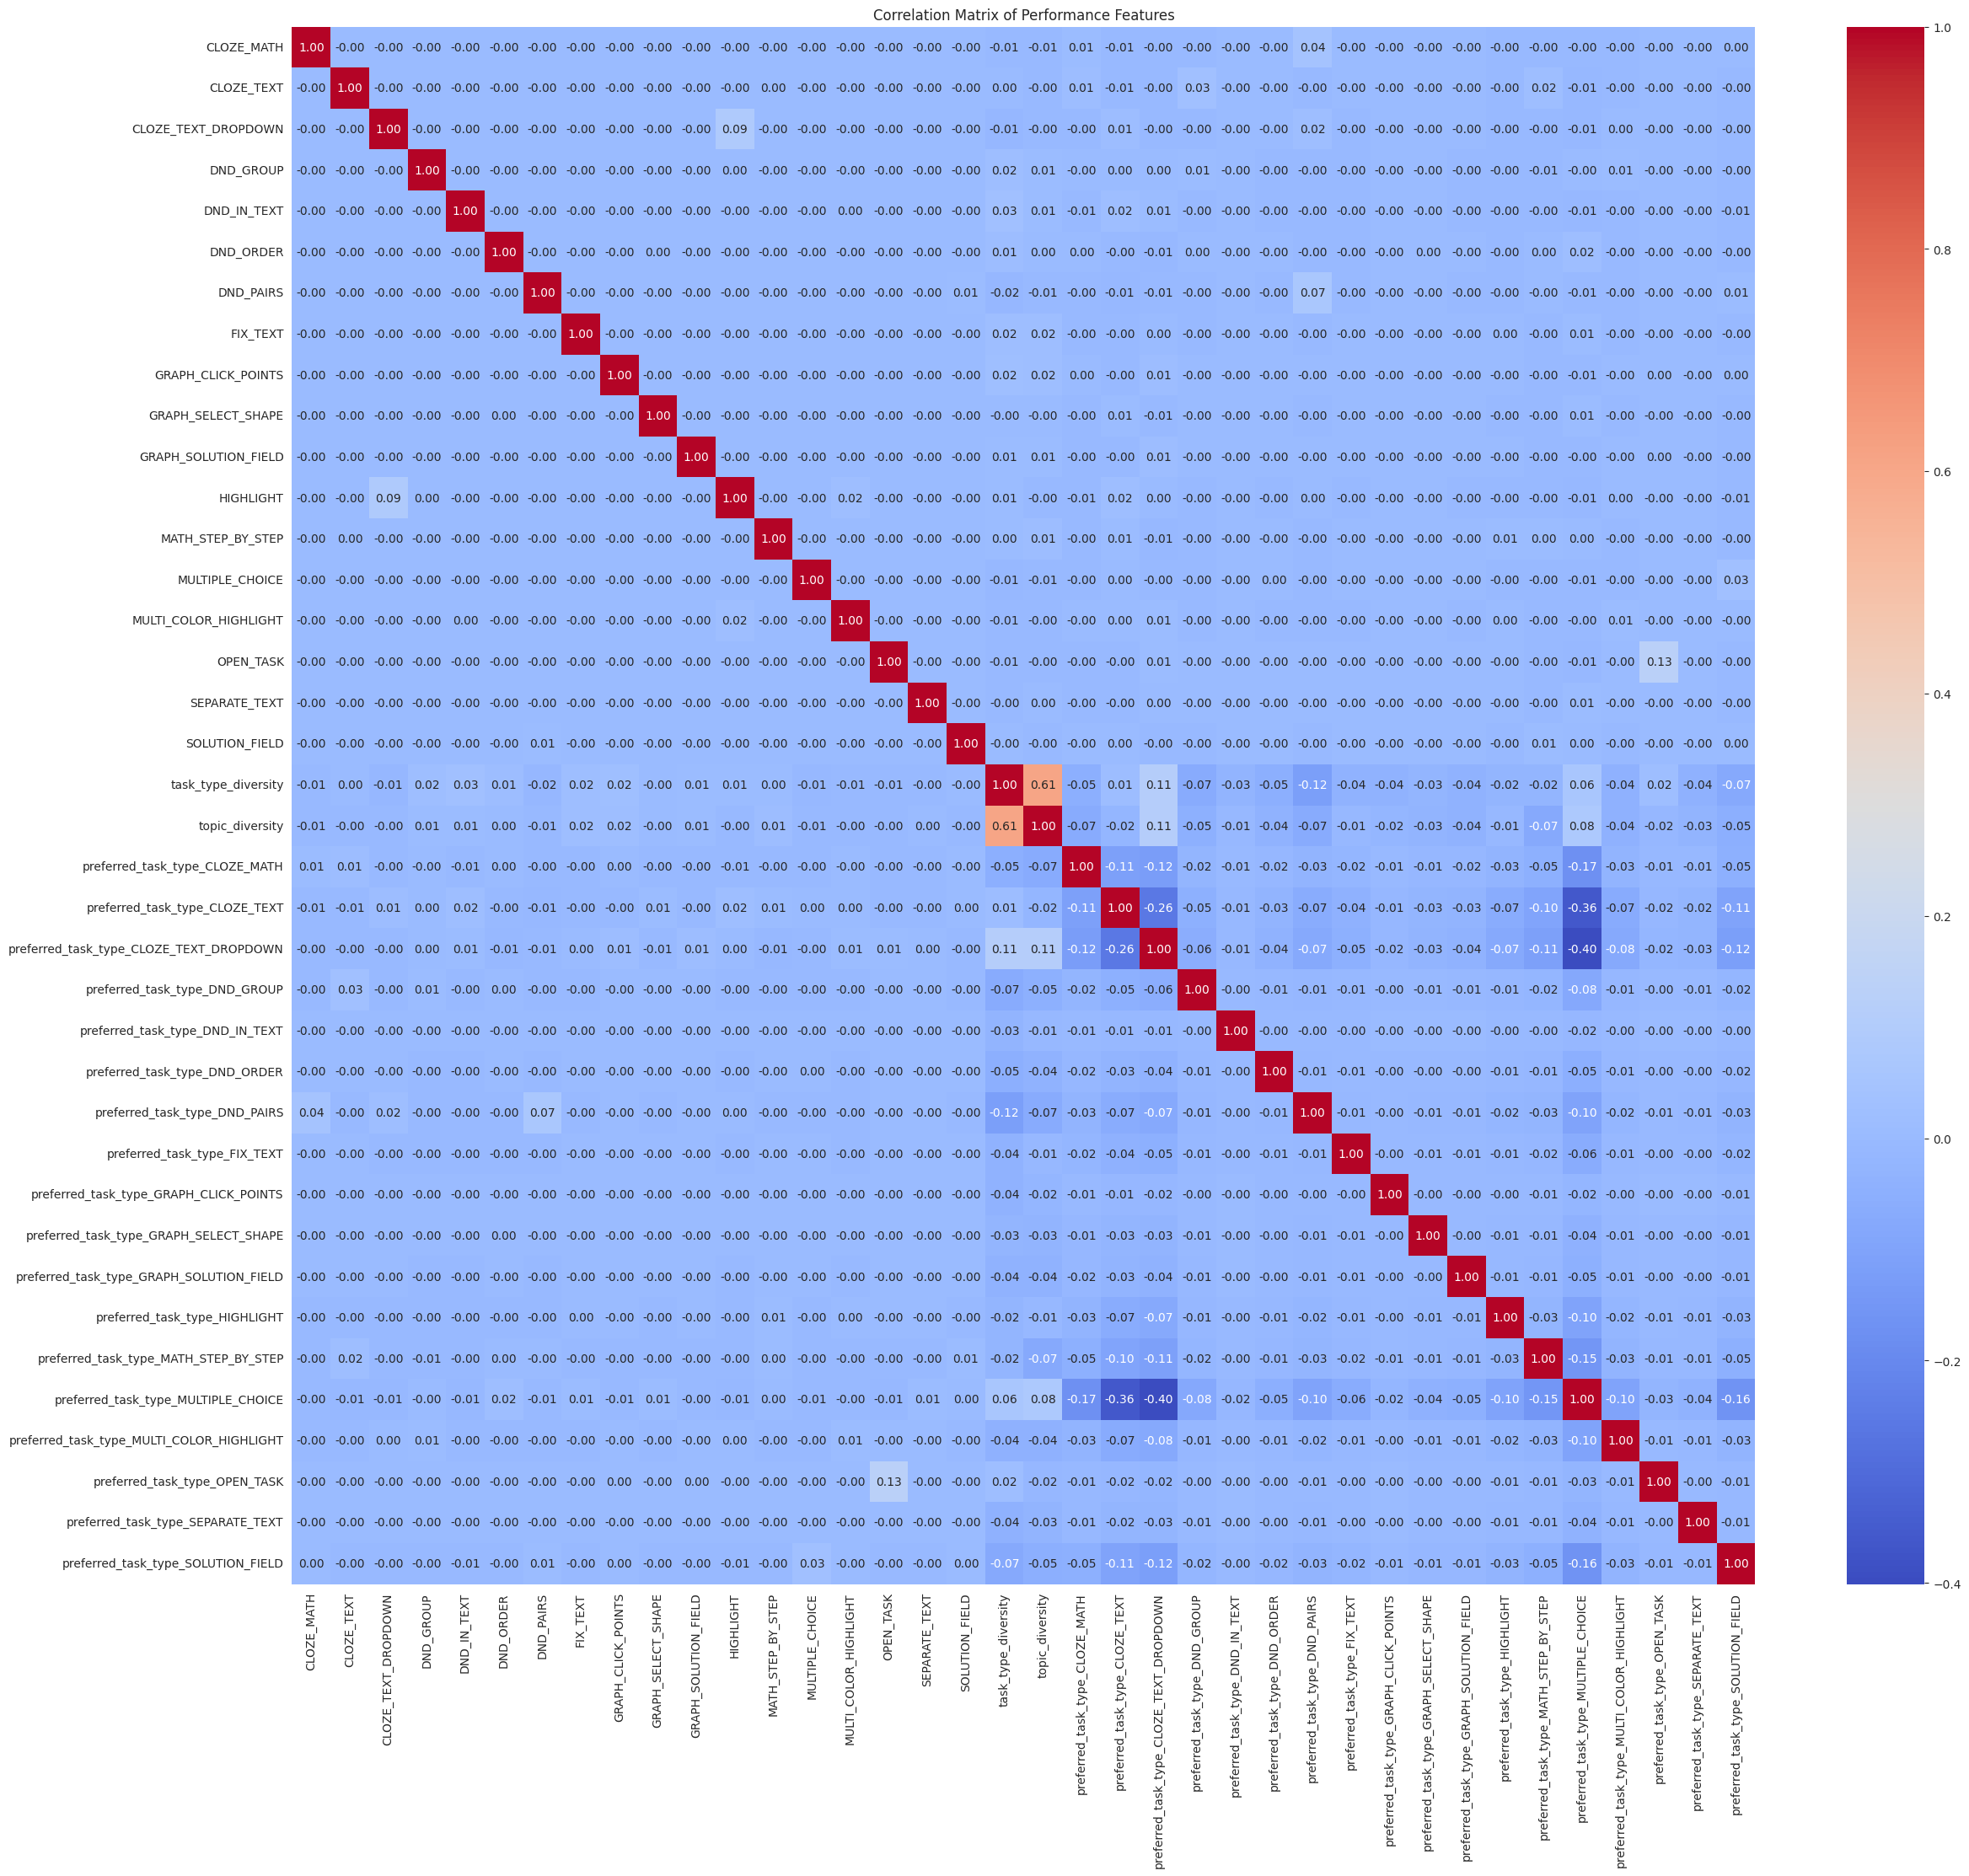

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix
plt.figure(figsize=(28, 24))
sns.heatmap(performance_features.drop('user_id', axis=1).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Performance Features')
plt.show()


In [30]:
from sklearn.preprocessing import StandardScaler

# Remove user_id column before scaling
X = performance_features.drop(columns=['user_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaled dataframe if you want
import pandas as pd
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()


CLOZE_MATH  CLOZE_TEXT  CLOZE_TEXT_DROPDOWN  DND_GROUP  DND_IN_TEXT  \
0   -0.015730   -0.020034            -0.020152  -0.024744    -0.023364   
1   -0.015473   -0.020021            -0.020171  -0.024069    -0.023272   
2   -0.015517   -0.020083            -0.020180  -0.024102    -0.023562   
3   -0.015730   -0.020083            -0.020231  -0.024907    -0.023562   
4   -0.015730   -0.020083            -0.020035  -0.024907    -0.023562   

   DND_ORDER  DND_PAIRS  FIX_TEXT  GRAPH_CLICK_POINTS  GRAPH_SELECT_SHAPE  \
0  -0.021055  -0.023565 -0.014760           -0.009598           -0.010862   
1  -0.021161  -0.023522 -0.014682           -0.007722           -0.010767   
2  -0.021021  -0.023530 -0.014863           -0.009387           -0.010745   
3  -0.021426  -0.023628 -0.014863           -0.009598           -0.010862   
4  -0.021426  -0.023628 -0.014863           -0.009598           -0.010862   

   ...  preferred_task_type_GRAPH_CLICK_POINTS  \
0  ...                               -0.028174   
1  ...                               -0.028174   
2  ...                               -0.028174   
3  ...                               -0.028174   
4  ...                               -0.028174   

   preferred_task_type_GRAPH_SELECT_SHAPE  \
0                               -0.058859   
1                               -0.058859   
2                               -0.058859   
3                               -0.058859   
4                               -0.058859   

   preferred_task_type_GRAPH_SOLUTION_FIELD  preferred_task_type_HIGHLIGHT  \
0                                 -0.067773                      -0.136134   
1                                 -0.067773                      -0.136134   
2                                 -0.067773                      -0.136134   
3                                 -0.067773                      -0.136134   
4                                 -0.067773                      -0.136134   

   preferred_task_type_MATH_STEP_BY_STEP  preferred_task_type_MULTIPLE_CHOICE  \
0                              -0.206670                            -0.747023   
1                              -0.206670                            -0.747023   
2                              -0.206670                             1.338647   
3                               4.838626                            -0.747023   
4                              -0.206670                             1.338647   

   preferred_task_type_MULTI_COLOR_HIGHLIGHT  preferred_task_type_OPEN_TASK  \
0                                  -0.140513                      -0.036808   
1                                  -0.140513                      -0.036808   
2                                  -0.140513                      -0.036808   
3                                  -0.140513                      -0.036808   
4                                  -0.140513                      -0.036808   

   preferred_task_type_SEPARATE_TEXT  preferred_task_type_SOLUTION_FIELD  
0                          -0.051181                           -0.219123  
1                          -0.051181                            4.563648  
2                          -0.051181                           -0.219123  
3                          -0.051181                           -0.219123  
4                          -0.051181                           -0.219123  

[5 rows x 38 columns]

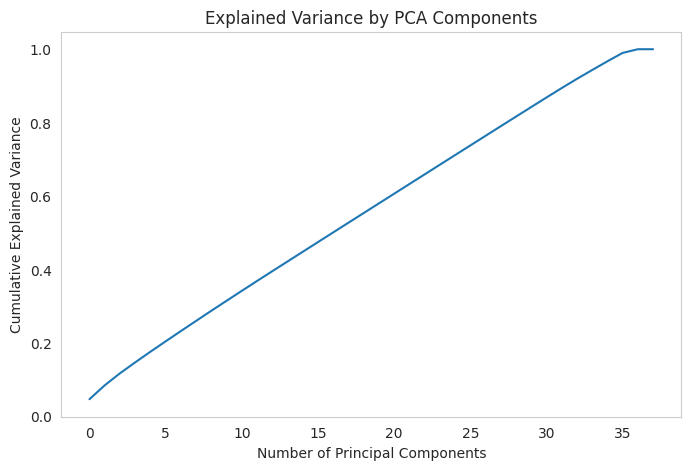

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA keeping all components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()


## Correlation and Dimensionality Analysis of Performance Features

We first analyzed the correlation matrix of the performance-based features:

- No strong correlations were detected (all below 0.9).
- Each feature provides distinct behavioral information.
- Therefore, we decided to keep all performance features for the clustering step.

We then performed a PCA to explore the possibility of dimensionality reduction:

- The cumulative explained variance increased steadily without a clear "elbow".
- A large number of components would be needed to capture sufficient variance.
- As a result, we decided to cluster directly on the full set of scaled features without applying dimensionality reduction.

## 2.3 Temporal Behavior Features

### Step 1: Prepare daily activity 

In [32]:
from functools import reduce

events['event_date'] = pd.to_datetime(events['event_date'])
events = events.sort_values(by=['user_id', 'event_date'])

daily_activity = events.groupby(['user_id', pd.Grouper(key='event_date', freq='D')])['event_id'].count().unstack(fill_value=0)

# Calculate temporal features
temporal_features = daily_activity.apply(lambda x: {
    'active_days': (x > 0).sum(),
    'mean_events': x.mean(),
    'time_var': x.std(),
    'weekend_ratio': x[x.index.weekday >= 5].sum() / x.sum() if x.sum() > 0 else 0
}, axis=1)

# Convert Series of dicts to dataframe
temporal_df = pd.DataFrame(temporal_features.tolist(), index=temporal_features.index).reset_index()
temporal_df = temporal_df.rename(columns={'index': 'user_id'})


### Step 2: Time between events

In [33]:

events['time_diff'] = events.groupby('user_id')['event_date'].diff().dt.total_seconds()

event_time_stats = events.groupby('user_id')['time_diff'].agg(['mean', 'std']).reset_index()
event_time_stats.columns = ['user_id', 'avg_time_between_events', 'std_time_between_events']

### Step 3: Merge temporal features

In [34]:
temporal_final = temporal_df.merge(event_time_stats, on='user_id', how='left')

# Check
temporal_final.head()

user_id  active_days  mean_events   time_var  weekend_ratio  \
0   387604          100     8.113238  33.566561       0.045606   
1   387605           54     5.748006  34.340947       0.185905   
2   387608           87     3.762360  14.224332       0.130140   
3   387613            5     0.339713   4.971908       0.089202   
4   387615           12     0.853270   8.696562       0.145794   

   avg_time_between_events  std_time_between_events  
0             10424.632556             1.237126e+05  
1             12543.136260             1.852490e+05  
2             18650.922512             1.588434e+05  
3            192817.528580             2.493983e+06  
4             84626.140627             1.073315e+06

In [35]:
# Check missing values
temporal_final.isnull().sum()

user_id                    0
active_days                0
mean_events                0
time_var                   0
weekend_ratio              0
avg_time_between_events    2
std_time_between_events    2
dtype: int64

In [36]:
# Fill missing time differences with 0 (meaning: no info about time gaps)
temporal_final['avg_time_between_events'] = temporal_final['avg_time_between_events'].fillna(0)
temporal_final['std_time_between_events'] = temporal_final['std_time_between_events'].fillna(0)


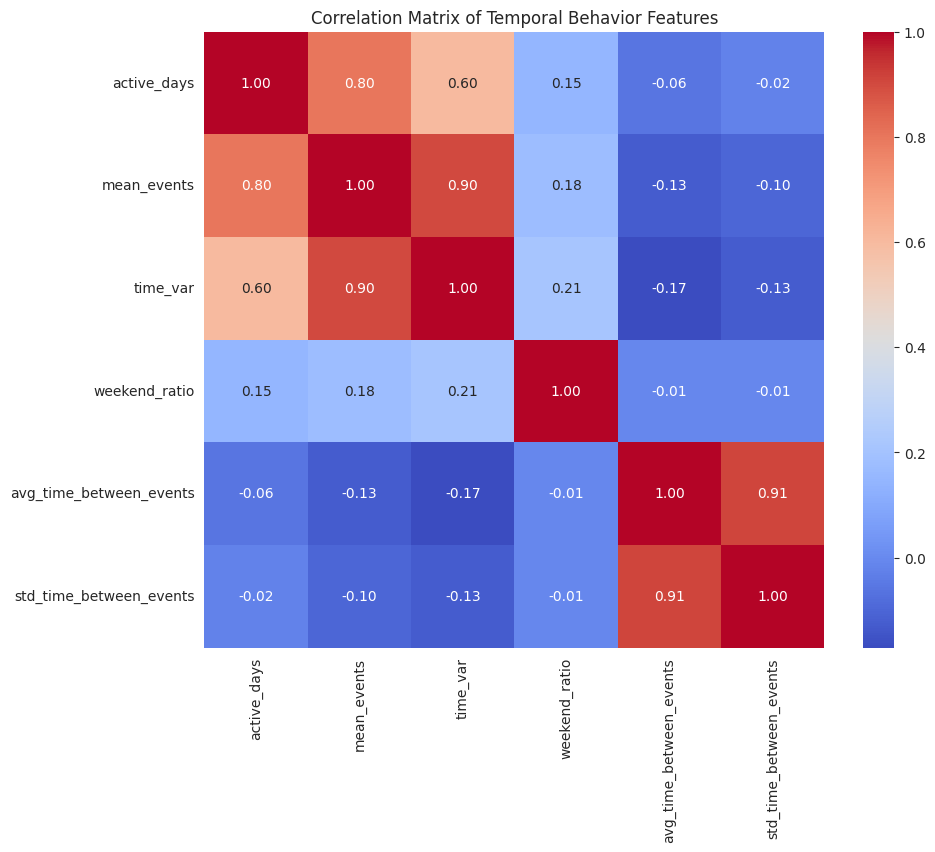

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot correlation heatmap for temporal features
plt.figure(figsize=(10,8))
sns.heatmap(temporal_final.drop(columns='user_id').corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Temporal Behavior Features')
plt.show()


In [38]:
# Keep only selected columns
temporal_final_clean = temporal_final[['user_id', 
                                       'active_days', 
                                       'mean_events', 
                                       'weekend_ratio', 
                                       'avg_time_between_events']]

# Check
temporal_final_clean.head()


user_id  active_days  mean_events  weekend_ratio  avg_time_between_events
0   387604          100     8.113238       0.045606             10424.632556
1   387605           54     5.748006       0.185905             12543.136260
2   387608           87     3.762360       0.130140             18650.922512
3   387613            5     0.339713       0.089202            192817.528580
4   387615           12     0.853270       0.145794             84626.140627

## Cleaning and Feature Selection for Temporal Behavior

We analyzed the correlation matrix of temporal behavior features.

- `mean_events` and `time_var` were highly correlated (0.90).
- `avg_time_between_events` and `std_time_between_events` were also highly correlated (0.91).

To avoid redundancy, we kept:
- `active_days`
- `mean_events`
- `weekend_ratio`
- `avg_time_between_events`

This ensures a diverse set of temporal behavior indicators without multicollinearity.


## 2.3 Consistensy Features

### Step 1 - Number of weeks active


In [39]:
# Extract week number
events['week'] = events['event_date'].dt.isocalendar().week

# Number of unique weeks active
weeks_active = events.groupby('user_id')['week'].nunique().reset_index()
weeks_active.columns = ['user_id', 'weeks_active']
weeks_active.head()


user_id  weeks_active
0   387604            38
1   387605            29
2   387608            41
3   387613             4
4   387615             8

### Step 2 - Number of "silent periods" (>7 days no activity)

In [40]:
# Time difference between consecutive events
events['event_gap_days'] = events.groupby('user_id')['event_date'].diff().dt.days

# Count how many times there is a gap >7 days
silent_periods = events.groupby('user_id')['event_gap_days'].apply(lambda x: (x > 7).sum()).reset_index()
silent_periods.columns = ['user_id', 'silent_periods']
silent_periods.head()


user_id  silent_periods
0   387604              17
1   387605              22
2   387608              18
3   387613               3
4   387615               4

### Step 3 - Merge Consistency Features

In [41]:
# Merge weeks_active and silent_periods
consistency_features = weeks_active.merge(silent_periods, on='user_id', how='left')

# Check
consistency_features.head()


user_id  weeks_active  silent_periods
0   387604            38              17
1   387605            29              22
2   387608            41              18
3   387613             4               3
4   387615             8               4

In [42]:
# Check missing values
consistency_features.isnull().sum()


user_id           0
weeks_active      0
silent_periods    0
dtype: int64

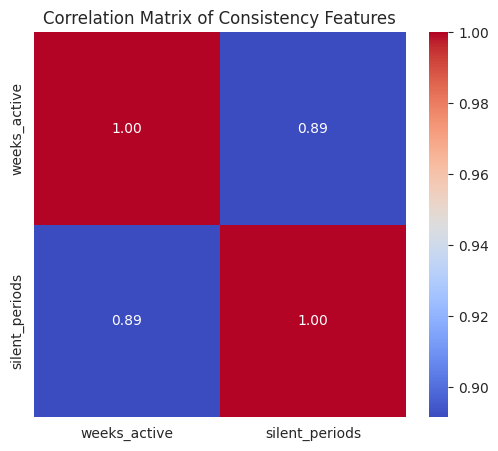

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix for consistency features
plt.figure(figsize=(6,5))
sns.heatmap(consistency_features.drop(columns='user_id').corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Consistency Features')
plt.show()


## Consistency Features Analysis

We created two consistency features:
- `weeks_active`: number of weeks the user was active
- `silent_periods`: number of inactivity gaps longer than 7 days

Their correlation was 0.89, indicating some relation but capturing complementary aspects of consistency.
Thus, both features were retained for clustering.


# 3. Merge and Correlation Analysis


In [44]:
from functools import reduce

# List of dataframes to merge
dfs_to_merge = [final_session_features, performance_features, temporal_final_clean, consistency_features]

# Merge all on user_id
features_final = reduce(lambda left, right: pd.merge(left, right, on='user_id', how='outer'), dfs_to_merge)

# Check
print(f"Shape of features_final: {features_final.shape}")
features_final.head()


Shape of features_final: (22470, 61)


user_id  total_sessions  total_num_events  avg_session_duration_min  \
0   387604            61.0            1105.0              12963.096278   
1   387605            67.0             742.0              29595.661530   
2   387608            31.0             469.0              11904.947317   
3   387613             4.0              31.0                  1.019733   
4   387615             2.0              48.0                  9.675450   

   median_session_duration_min  std_session_duration_min  \
0                     1.331083              64843.133625   
1                     3.315933              98793.615011   
2                     3.627667              40661.940478   
3                     0.923208                  0.581060   
4                     9.675450                  0.642996   

   max_session_duration_min  min_session_duration_min  \
0             492921.146800                  0.000000   
1             531286.253133                  0.000000   
2             217246.262683                  0.000000   
3                  1.766600                  0.465917   
4                 10.130117                  9.220783   

   avg_num_events_per_session  avg_unique_topics_per_session  ...  \
0                   18.114754                       0.918033  ...   
1                   11.074627                       0.955224  ...   
2                   15.129032                       0.548387  ...   
3                    7.750000                       1.000000  ...   
4                   24.000000                       1.000000  ...   

   preferred_task_type_MULTI_COLOR_HIGHLIGHT  preferred_task_type_OPEN_TASK  \
0                                      False                          False   
1                                      False                          False   
2                                      False                          False   
3                                      False                          False   
4                                      False                          False   

   preferred_task_type_SEPARATE_TEXT  preferred_task_type_SOLUTION_FIELD  \
0                              False                               False   
1                              False                                True   
2                              False                               False   
3                              False                               False   
4                              False                               False   

   active_days  mean_events  weekend_ratio  avg_time_between_events  \
0          100     8.113238       0.045606             10424.632556   
1           54     5.748006       0.185905             12543.136260   
2           87     3.762360       0.130140             18650.922512   
3            5     0.339713       0.089202            192817.528580   
4           12     0.853270       0.145794             84626.140627   

   weeks_active  silent_periods  
0            38              17  
1            29              22  
2            41              18  
3             4               3  
4             8               4  

[5 rows x 61 columns]

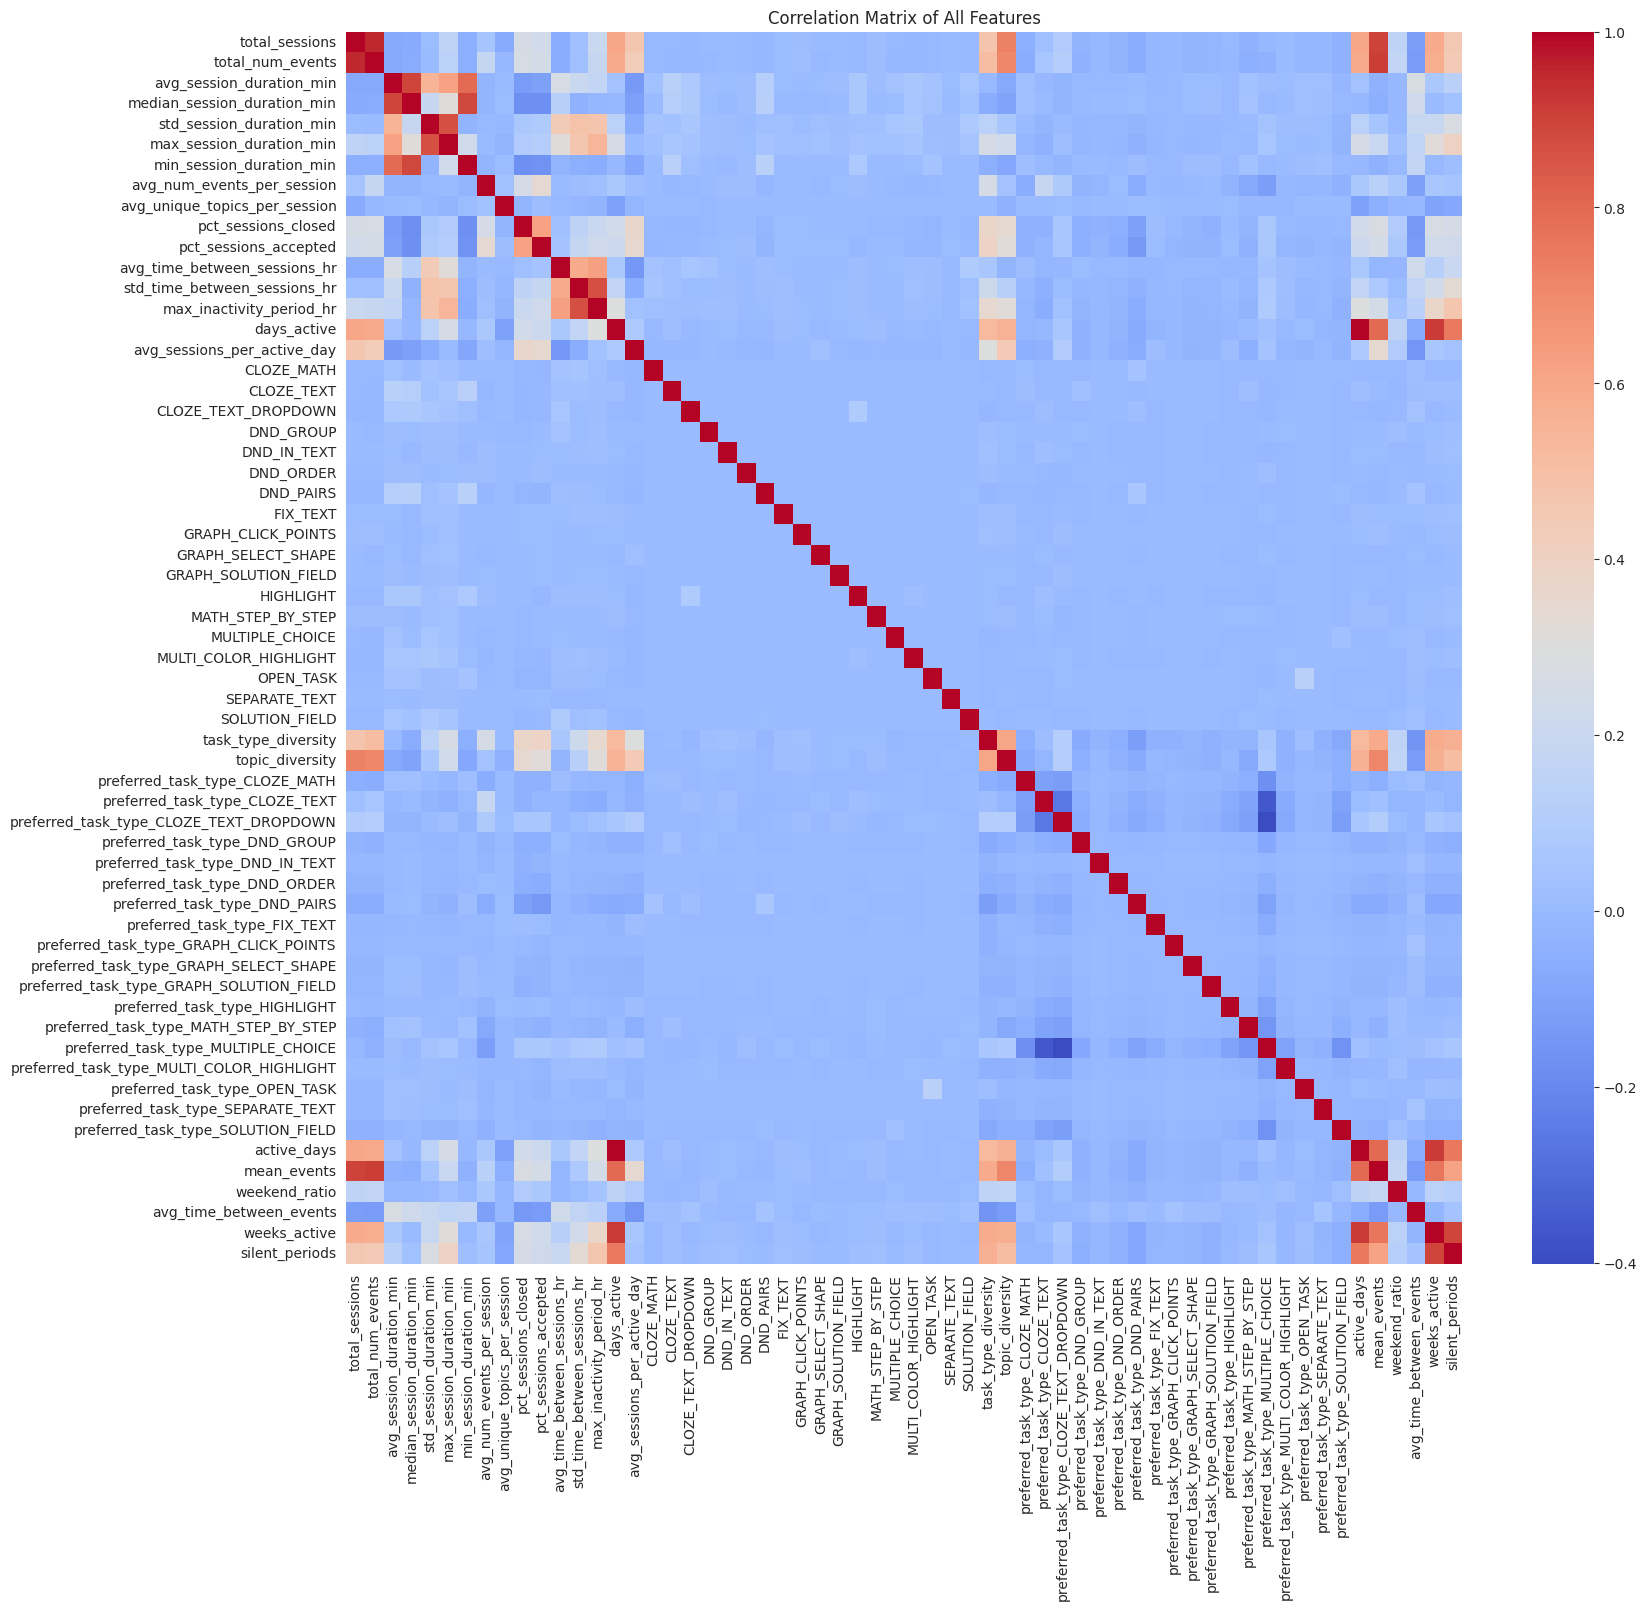

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop user_id for correlation
plt.figure(figsize=(18, 16))
sns.heatmap(features_final.drop(columns='user_id').corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of All Features')
plt.show()


# 3. Correlation Analysis and Feature Selection

We analyzed the full correlation matrix across session, performance, temporal, and consistency features.

- Within session-based features, high correlations were observed between `total_sessions` and `total_num_events`, as well as among session duration statistics.
- To avoid redundancy, we dropped `total_num_events` and `min_session_duration_min`.

Performance, temporal, and consistency features showed acceptable levels of correlation, and all were retained.

This feature selection ensures a diverse and independent set of behavioral indicators for clustering.


In [46]:
# --- 1. Drop redundant features from features_final ---

# Columns to drop based on correlation analysis
columns_to_drop = [
    'total_num_events',          # Highly correlated with total_sessions
    'min_session_duration_min',  # Low info + correlated with other durations
    'median_session_duration_min'  # Optional: you can comment this line if you want to keep it
]

# Drop them
features_final_clean = features_final.drop(columns=columns_to_drop)

# Check the new shape
print(f"Shape after dropping redundant features: {features_final_clean.shape}")
features_final_clean.head()


Shape after dropping redundant features: (22470, 58)


user_id  total_sessions  avg_session_duration_min  \
0   387604            61.0              12963.096278   
1   387605            67.0              29595.661530   
2   387608            31.0              11904.947317   
3   387613             4.0                  1.019733   
4   387615             2.0                  9.675450   

   std_session_duration_min  max_session_duration_min  \
0              64843.133625             492921.146800   
1              98793.615011             531286.253133   
2              40661.940478             217246.262683   
3                  0.581060                  1.766600   
4                  0.642996                 10.130117   

   avg_num_events_per_session  avg_unique_topics_per_session  \
0                   18.114754                       0.918033   
1                   11.074627                       0.955224   
2                   15.129032                       0.548387   
3                    7.750000                       1.000000   
4                   24.000000                       1.000000   

   pct_sessions_closed  pct_sessions_accepted  avg_time_between_sessions_hr  \
0             0.982143               0.826087                    229.595889   
1             0.984375               1.000000                    187.273808   
2             1.000000               1.000000                    407.203174   
3             0.750000               1.000000                    439.497068   
4             1.000000               1.000000                      0.172846   

   ...  preferred_task_type_MULTI_COLOR_HIGHLIGHT  \
0  ...                                      False   
1  ...                                      False   
2  ...                                      False   
3  ...                                      False   
4  ...                                      False   

   preferred_task_type_OPEN_TASK  preferred_task_type_SEPARATE_TEXT  \
0                          False                              False   
1                          False                              False   
2                          False                              False   
3                          False                              False   
4                          False                              False   

   preferred_task_type_SOLUTION_FIELD  active_days  mean_events  \
0                               False          100     8.113238   
1                                True           54     5.748006   
2                               False           87     3.762360   
3                               False            5     0.339713   
4                               False           12     0.853270   

   weekend_ratio  avg_time_between_events  weeks_active  silent_periods  
0       0.045606             10424.632556            38              17  
1       0.185905             12543.136260            29              22  
2       0.130140             18650.922512            41              18  
3       0.089202            192817.528580             4               3  
4       0.145794             84626.140627             8               4  

[5 rows x 58 columns]

In [47]:
from sklearn.feature_selection import VarianceThreshold

# Remove very low-variance features (threshold = 0.01 is common)
selector = VarianceThreshold(threshold=0.01)
features_selected = selector.fit_transform(features_final_clean.drop(columns='user_id'))

print(f"Original shape: {features_final_clean.drop(columns='user_id').shape}")
print(f"After Variance Threshold: {features_selected.shape}")


# Recover the column names that were kept
selected_columns = features_final_clean.drop(columns=['user_id']).columns[selector.get_support()]

# Check
print(f"Selected {len(selected_columns)} features:")
print(selected_columns.tolist())


Original shape: (22470, 57)
After Variance Threshold: (22470, 48)
Selected 48 features:
['total_sessions', 'avg_session_duration_min', 'std_session_duration_min', 'max_session_duration_min', 'avg_num_events_per_session', 'pct_sessions_closed', 'pct_sessions_accepted', 'avg_time_between_sessions_hr', 'std_time_between_sessions_hr', 'max_inactivity_period_hr', 'days_active', 'avg_sessions_per_active_day', 'CLOZE_MATH', 'CLOZE_TEXT', 'CLOZE_TEXT_DROPDOWN', 'DND_GROUP', 'DND_IN_TEXT', 'DND_ORDER', 'DND_PAIRS', 'FIX_TEXT', 'GRAPH_CLICK_POINTS', 'GRAPH_SELECT_SHAPE', 'GRAPH_SOLUTION_FIELD', 'HIGHLIGHT', 'MATH_STEP_BY_STEP', 'MULTIPLE_CHOICE', 'MULTI_COLOR_HIGHLIGHT', 'OPEN_TASK', 'SEPARATE_TEXT', 'SOLUTION_FIELD', 'task_type_diversity', 'topic_diversity', 'preferred_task_type_CLOZE_MATH', 'preferred_task_type_CLOZE_TEXT', 'preferred_task_type_CLOZE_TEXT_DROPDOWN', 'preferred_task_type_DND_GROUP', 'preferred_task_type_DND_PAIRS', 'preferred_task_type_HIGHLIGHT', 'preferred_task_type_MATH_STEP

# 4. Prepare Final Feature Table
After merging and cleaning all feature families, we applied a Variance Threshold analysis with a threshold of 0.01.

- 57 features were initially available.
- 48 features were retained after removing near-constant features.

This step ensures that only informative and varying features are used for clustering.


In [48]:
import pandas as pd

# Rebuild clean dataframe
X_selected_df = pd.DataFrame(features_selected, columns=selected_columns)

# Add user_id back if you want
X_selected_df['user_id'] = features_final_clean['user_id'].values

# Check
X_selected_df.head()


total_sessions avg_session_duration_min std_session_duration_min  \
0           61.0             12963.096278             64843.133625   
1           67.0              29595.66153             98793.615011   
2           31.0             11904.947317             40661.940478   
3            4.0                 1.019733                  0.58106   
4            2.0                  9.67545                 0.642996   

  max_session_duration_min avg_num_events_per_session pct_sessions_closed  \
0              492921.1468                  18.114754            0.982143   
1            531286.253133                  11.074627            0.984375   
2            217246.262683                  15.129032                 1.0   
3                   1.7666                       7.75                0.75   
4                10.130117                       24.0                 1.0   

  pct_sessions_accepted avg_time_between_sessions_hr  \
0              0.826087                   229.595889   
1                   1.0                   187.273808   
2                   1.0                   407.203174   
3                   1.0                   439.497068   
4                   1.0                     0.172846   

  std_time_between_sessions_hr max_inactivity_period_hr  ...  \
0                   425.555724              1676.341603  ...   
1                   464.944778              3120.276084  ...   
2                   787.446374              3049.412006  ...   
3                   548.218223              1053.816563  ...   
4                          0.0                 0.172846  ...   

  preferred_task_type_MULTIPLE_CHOICE  \
0                               False   
1                               False   
2                                True   
3                               False   
4                                True   

  preferred_task_type_MULTI_COLOR_HIGHLIGHT  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

  preferred_task_type_SOLUTION_FIELD active_days mean_events weekend_ratio  \
0                              False         100    8.113238      0.045606   
1                               True          54    5.748006      0.185905   
2                              False          87     3.76236       0.13014   
3                              False           5    0.339713      0.089202   
4                              False          12     0.85327      0.145794   

  avg_time_between_events weeks_active silent_periods user_id  
0            10424.632556           38             17  387604  
1             12543.13626           29             22  387605  
2            18650.922512           41             18  387608  
3            192817.52858            4              3  387613  
4            84626.140627            8              4  387615  

[5 rows x 49 columns]

In [49]:
from sklearn.preprocessing import StandardScaler

# Separate user_id and features
X_features_final = X_selected_df.drop(columns=['user_id'])
user_ids_final = X_selected_df['user_id']

# Apply scaling
scaler = StandardScaler()
X_scaled_final_clustering = scaler.fit_transform(X_features_final)
X_scaled_final_clustering = pd.DataFrame(X_scaled_final_clustering, columns=X_features_final.columns)

# Optionally wrap back into a DataFrame for easier analysis
import pandas as pd
X_scaled_final_df = X_scaled_final_clustering.copy()
X_scaled_final_df['user_id'] = user_ids_final.values

# Check
X_scaled_final_df.head()


total_sessions  avg_session_duration_min  std_session_duration_min  \
0        2.178260                  0.040976                  1.091944   
1        2.445658                  0.468185                  1.881149   
2        0.841269                  0.013797                  0.529834   
3       -0.362023                 -0.291957                 -0.415370   
4       -0.451156                 -0.291734                 -0.415368   

   max_session_duration_min  avg_num_events_per_session  pct_sessions_closed  \
0                  3.761500                    0.114304             0.591600   
1                  4.092042                   -0.519263             0.598772   
2                  1.386367                   -0.154392             0.648977   
3                 -0.485347                   -0.818458            -0.154303   
4                 -0.485275                    0.643939             0.648977   

   pct_sessions_accepted  avg_time_between_sessions_hr  \
0               0.156031                     -0.027532   
1               0.574557                     -0.088120   
2               0.574557                      0.226730   
3               0.574557                      0.272961   
4               0.574557                     -0.355972   

   std_time_between_sessions_hr  max_inactivity_period_hr  ...  \
0                      0.017587                  0.189341  ...   
1                      0.066162                  0.865307  ...   
2                      0.463874                  0.832133  ...   
3                      0.168855                 -0.102089  ...   
4                     -0.507214                 -0.595344  ...   

   preferred_task_type_MULTIPLE_CHOICE  \
0                            -0.747023   
1                            -0.747023   
2                             1.338647   
3                            -0.747023   
4                             1.338647   

   preferred_task_type_MULTI_COLOR_HIGHLIGHT  \
0                                  -0.140513   
1                                  -0.140513   
2                                  -0.140513   
3                                  -0.140513   
4                                  -0.140513   

   preferred_task_type_SOLUTION_FIELD  active_days  mean_events  \
0                           -0.219123    11.997447     5.806972   
1                            4.563648     6.115191     3.930310   
2                           -0.219123    10.335071     2.354826   
3                           -0.219123    -0.150690    -0.360828   
4                           -0.219123     0.744436     0.046646   

   weekend_ratio  avg_time_between_events  weeks_active  silent_periods  \
0      -0.183118                -0.325153      8.649997        6.477566   
1       0.603994                -0.304138      6.354716        8.630960   
2       0.291138                -0.243549      9.415091        6.908245   
3       0.061465                 1.484182     -0.021065        0.448063   
4       0.378964                 0.410925      0.999060        0.878742   

   user_id  
0   387604  
1   387605  
2   387608  
3   387613  
4   387615  

[5 rows x 49 columns]

In [50]:
# Quick statistical summary
X_scaled_final_df.describe()


total_sessions  avg_session_duration_min  std_session_duration_min  \
count    1.963000e+04              1.963000e+04              1.963000e+04   
mean     2.316594e-17              1.158297e-17             -2.316594e-17   
std      1.000025e+00              1.000025e+00              1.000025e+00   
min     -4.957220e-01             -2.919828e-01             -4.153834e-01   
25%     -4.511556e-01             -2.918388e-01             -4.153320e-01   
50%     -3.174565e-01             -2.850633e-01             -4.086639e-01   
75%      3.907447e-02             -1.253779e-01             -7.101247e-02   
max      2.789306e+01              1.893648e+01              1.386980e+01   

       max_session_duration_min  avg_num_events_per_session  \
count              19630.000000                1.963000e+04   
mean                   0.000000                1.151058e-16   
std                    1.000025                1.000025e+00   
min                   -0.485362               -1.425915e+00   
25%                   -0.485270               -5.409774e-01   
50%                   -0.470655               -1.283093e-01   
75%                   -0.013252                3.019629e-01   
max                    7.002381                1.432297e+01   

       pct_sessions_closed  pct_sessions_accepted  \
count         1.963000e+04           1.963000e+04   
mean         -4.633187e-17           8.108078e-17   
std           1.000025e+00           1.000025e+00   
min          -2.564143e+00          -1.831966e+00   
25%          -1.543032e-01           1.233336e-01   
50%           4.883207e-01           5.745565e-01   
75%           6.489766e-01           5.745565e-01   
max           6.489766e-01           5.745565e-01   

       avg_time_between_sessions_hr  std_time_between_sessions_hr  \
count                  19630.000000                  1.963000e+04   
mean                       0.000000                 -1.158297e-17   
std                        1.000025                  1.000025e+00   
min                       -0.356219                 -5.072139e-01   
25%                       -0.356127                 -5.072139e-01   
50%                       -0.316087                 -4.527768e-01   
75%                       -0.037022                  9.610756e-02   
max                       20.379959                  1.056108e+01   

       max_inactivity_period_hr  ...  preferred_task_type_MULTIPLE_CHOICE  \
count              1.963000e+04  ...                         2.143400e+04   
mean              -4.633187e-17  ...                        -6.364850e-17   
std                1.000025e+00  ...                         1.000023e+00   
min               -5.954253e-01  ...                        -7.470229e-01   
25%               -5.953802e-01  ...                        -7.470229e-01   
50%               -5.167953e-01  ...                        -7.470229e-01   
75%                1.856635e-01  ...                         1.338647e+00   
max                6.185469e+00  ...                         1.338647e+00   

       preferred_task_type_MULTI_COLOR_HIGHLIGHT  \
count                               2.143400e+04   
mean                               -2.652021e-17   
std                                 1.000023e+00   
min                                -1.405135e-01   
25%                                -1.405135e-01   
50%                                -1.405135e-01   
75%                                -1.405135e-01   
max                                 7.116754e+00   

       preferred_task_type_SOLUTION_FIELD   active_days   mean_events  \
count                        2.143400e+04  2.247000e+04  2.247000e+04   
mean                        -3.845431e-17 -2.023798e-17 -2.023798e-17   
std                          1.000023e+00  1.000022e+00  1.000022e+00   
min                         -2.191229e-01 -6.621906e-01 -6.291035e-01   
25%                         -2.191229e-01 -5.343154e-01 -4.937004e-01   
50%                         -2.191229e-01 -2

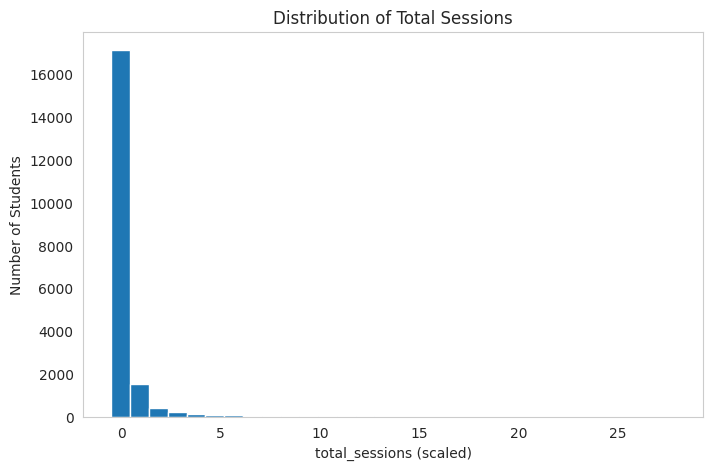

In [51]:
import matplotlib.pyplot as plt

# Example: distribution of total_sessions
plt.figure(figsize=(8,5))
plt.hist(X_scaled_final_df['total_sessions'], bins=30)
plt.title('Distribution of Total Sessions')
plt.xlabel('total_sessions (scaled)')
plt.ylabel('Number of Students')
plt.grid()
plt.show()


# 5. Save for Clustering


In [52]:
import pickle

# 1. Save scaled features + user id
X_scaled_final_df.to_csv('final_scaled_features_with_userid.csv', index=False)

# 2. Save clean feature matrix for clustering
X_scaled_final_clustering.to_csv('final_features_for_clustering.csv', index=False)
#np.save('final_features_for_clustering.npy', X_scaled_final)

# 3. Save scaler (optional but good)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ Saved all files for clustering.")


✅ Saved all files for clustering.


*Your discussion about your processing decisions goes here*

## Task 2: Model Building

Train a model for your research question.

### Prepare datasets for clustering
We will use different DataFrames in order to have a better overview on the clustering. Now that we have the features, we need to prepare them to be exactly on the correct format. But first, handling those big datasets eats a lot of RAM. Hence, it is a good practice to free some memory first.

In [53]:
# See memory usage
see_memory_usage(globals().items())

Variable               Type       Size
0         df_events          DataFrame   20.06 GB
1            events          DataFrame   19.84 GB
2      transactions          DataFrame    5.12 GB
3   df_transactions          DataFrame    4.65 GB
4    daily_activity          DataFrame  215.32 MB
..              ...                ...        ...
56        time_cols               list       72 B
57         DATA_DIR                str       56 B
58           scaler     StandardScaler       48 B
59              pca                PCA       48 B
60         selector  VarianceThreshold       48 B

[61 rows x 3 columns]

In [54]:
# Free some memory by deleting the biggest DataFrames and calling the garbage collector
del transactions, events, users, X_selected_df, features_final, df_events, df_transactions, daily_activity
gc.collect()

4920

In [55]:
# For the final Dataset

# Since the least number of NaNs in a row is 12, those rows are not very important for our clustering of the entire dataset:
nan_df = X_scaled_final_clustering.isnull().sum(axis=1)
print(f'Number of row with at least one NaN: {len(nan_df)}')
print(f'Min number of NaNs in a single row: {nan_df[nan_df > 0].sort_values().iloc[0]}')
del nan_df

# Then, we drop the NaNs (the clustering algorithms does not do well on NaN values)
X_scaled_final_clustering.dropna(how='any', inplace=True)

Number of row with at least one NaN: 22470
Min number of NaNs in a single row: 12


# HDBSCAN

## For entire dataset

#### Hyperparameter tuning
In order to get good results, hyperparameter finetuning is mandatory. To do this, let's do a simple grid search: run our HDBSCAN clustering on many hyperparameters and keep the bests. The most important hyperparameters for DBSCAN are 'min_cluster_size', which decides from which number of points a cluster can be considered, and 'cluster_selection_epsilon' which decides at which point to similar clusters must be considered as one.

In [235]:
# Initialize the parameters to be tuned
min_cluster_size_list = [10, 30, 50, 70]
cluster_selection_epsilon_list = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(X_scaled_final_clustering, min_cluster_size_list, cluster_selection_epsilon_list)

For min_cluster_size=10 and cluster_selection_epsilon=0.0:
	Nb clusters: 36
	Nb outliers: 10158
	Silhouette score: -0.10735474498846909
For min_cluster_size=10 and cluster_selection_epsilon=2.0:
	Nb clusters: 14
	Nb outliers: 2977
	Silhouette score: 0.07694640703699414
For min_cluster_size=10 and cluster_selection_epsilon=4.0:
	Nb clusters: 9
	Nb outliers: 571
	Silhouette score: 0.21980159076443567
For min_cluster_size=10 and cluster_selection_epsilon=6.0:
	Nb clusters: 6
	Nb outliers: 234
	Silhouette score: 0.3210849930976603
For min_cluster_size=10 and cluster_selection_epsilon=8.0:
	Nb clusters: 3
	Nb outliers: 152
	Silhouette score: 0.40242050068616786
For min_cluster_size=10 and cluster_selection_epsilon=10.0:
	Nb clusters: 3
	Nb outliers: 152
	Silhouette score: 0.40242050068616786
-----------------------------------
For min_cluster_size=30 and cluster_selection_epsilon=0.0:
	Nb clusters: 16
	Nb outliers: 7094
	Silhouette score: 0.029350287593603946
For min_cluster_size=30 and clu

### Plot the heatmap
We now have to analyze the hyperparameters in order to keep the best ones.

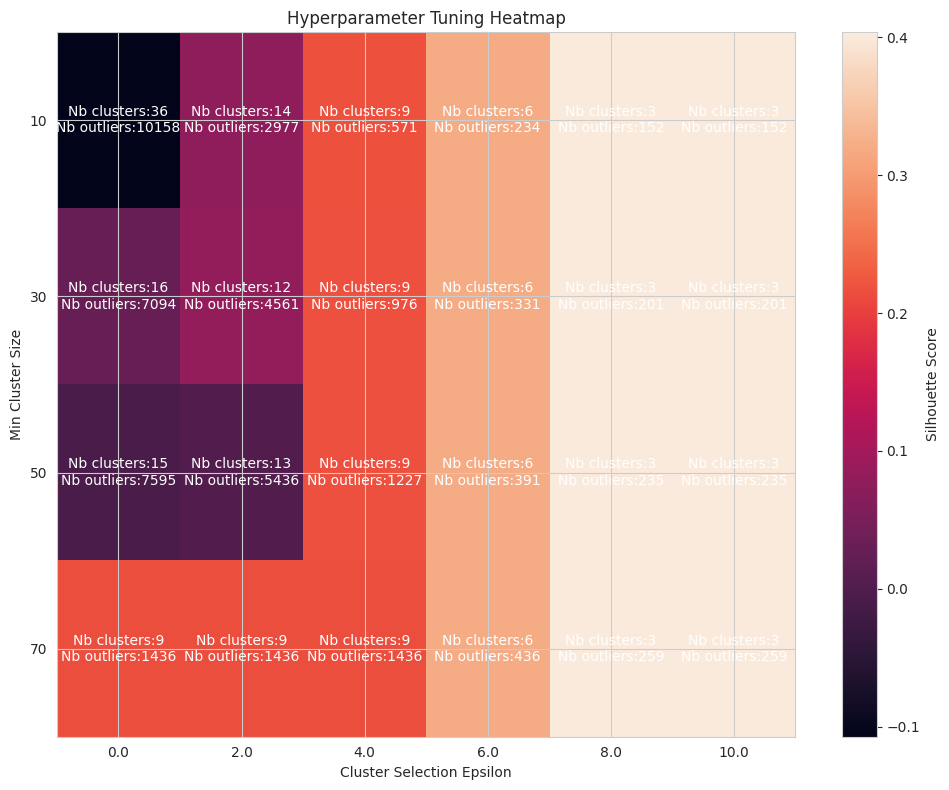

In [236]:
# Let's plot the heatmap
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

### Analysing the gridsearch
The insights given by the gridsearch analysis shows us that the min cluster size does not really influence the results for good ones. Moreover, the cluster selection epsilon permits to drastically decrease the number of clusters and increase the silhouette score. It is up to us to decide which number of clusters best represent what we want to show:
- Nb clusters 6 (with outliers): This is the most number of clusters we can have with a 'correct' silhouette score (0.32). Since this is an acceptable score, the clusters are however not really well separated.
- Nb clusters 3 (with outliers): With a silhouette score of 0.40, this is the best we could have. We have now to decide if three clusters suffices to extract interesting behaviors.

### Fit and analyse the clusters
Now that we found some good hyperparameters, let's visualize the 3 and 6 clusters and analyse those.

In [237]:
# Fit for 6 clusters
entire_dataset_6clusters, entire_dataset_6clusters_centroids = init_fit_hdbscan_clustering(X_scaled_final_clustering, min_cluster_size=30, cluster_selection_epsilon=6.0)

Model fitted. Num of clusters found: 5
Labels and probabilities added


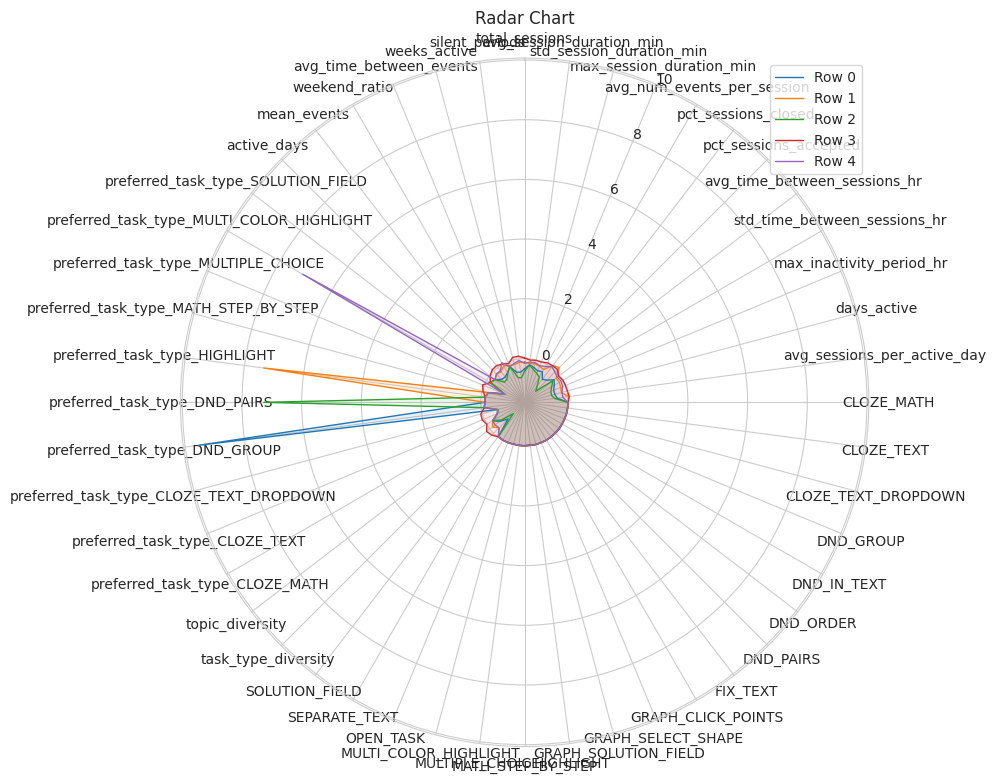

In [238]:
# Create radar chart
create_radar_chart(entire_dataset_6clusters_centroids)

In [239]:
# Count the number of samples per cluster
entire_dataset_6clusters['labels'].value_counts()

labels
 3    17431
 1      350
 2      338
-1      331
 4      315
 0      180
Name: count, dtype: int64

Model fitted. Num of clusters found: 2
Labels and probabilities added


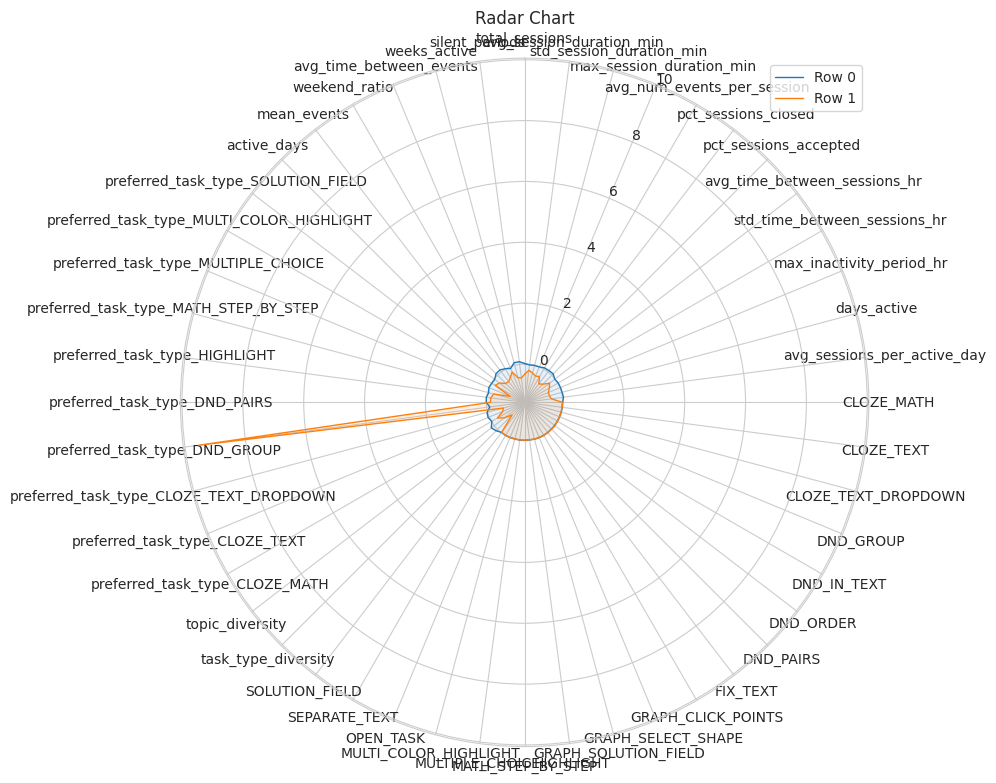

In [240]:
# Fit and plot for the 3-clusters
entire_dataset_3clusters, entire_dataset_3clusters_centroids = init_fit_hdbscan_clustering(X_scaled_final_clustering, min_cluster_size=30, cluster_selection_epsilon=8.0)
create_radar_chart(entire_dataset_3clusters_centroids)

In [241]:
# Count the number of samples in each cluster
entire_dataset_3clusters['labels'].value_counts()

labels
 0    18564
-1      201
 1      180
Name: count, dtype: int64

#### Analysis
We directly see that the clusters are defined mainly by one value. It makes sense since the 'preferred_*' columns are binary values, hence samples being similar here will have exactly the same value, which is confusing HDBSCAN. Therefore, we cannot extract a lot of meaningful information from these graphs.

## For dataset without preferred columns
We saw that the columns 'preferred_*' are mainly determining the clusters. To counter this, we could just remove these columns.

In [242]:
# We drop the 'preferred_*' columns
X_without_preferred = X_scaled_final_clustering.drop(['preferred_task_type_MULTI_COLOR_HIGHLIGHT', 'preferred_task_type_CLOZE_MATH', 'preferred_task_type_CLOZE_TEXT', 'preferred_task_type_CLOZE_TEXT_DROPDOWN', 'preferred_task_type_DND_GROUP', 'preferred_task_type_DND_PAIRS', 'preferred_task_type_HIGHLIGHT', 'preferred_task_type_MATH_STEP_BY_STEP', 'preferred_task_type_MULTIPLE_CHOICE', 'preferred_task_type_SOLUTION_FIELD'], axis=1)

In [243]:
X_without_preferred.head()

total_sessions  avg_session_duration_min  std_session_duration_min  \
0        2.178260                  0.040976                  1.091944   
1        2.445658                  0.468185                  1.881149   
2        0.841269                  0.013797                  0.529834   
3       -0.362023                 -0.291957                 -0.415370   
4       -0.451156                 -0.291734                 -0.415368   

   max_session_duration_min  avg_num_events_per_session  pct_sessions_closed  \
0                  3.761500                    0.114304             0.591600   
1                  4.092042                   -0.519263             0.598772   
2                  1.386367                   -0.154392             0.648977   
3                 -0.485347                   -0.818458            -0.154303   
4                 -0.485275                    0.643939             0.648977   

   pct_sessions_accepted  avg_time_between_sessions_hr  \
0               0.156031                     -0.027532   
1               0.574557                     -0.088120   
2               0.574557                      0.226730   
3               0.574557                      0.272961   
4               0.574557                     -0.355972   

   std_time_between_sessions_hr  max_inactivity_period_hr  ...  SEPARATE_TEXT  \
0                      0.017587                  0.189341  ...      -0.009419   
1                      0.066162                  0.865307  ...      -0.009490   
2                      0.463874                  0.832133  ...      -0.009574   
3                      0.168855                 -0.102089  ...      -0.009574   
4                     -0.507214                 -0.595344  ...      -0.009425   

   SOLUTION_FIELD  task_type_diversity  topic_diversity  active_days  \
0       -0.016840             1.623130         2.142383    11.997447   
1       -0.016743             3.379855         4.961933     6.115191   
2       -0.016784             1.037556         1.708606    10.335071   
3       -0.016778            -1.304744        -0.026501    -0.150690   
4       -0.016840            -1.011957        -0.677167     0.744436   

   mean_events  weekend_ratio  avg_time_between_events  weeks_active  \
0     5.806972      -0.183118                -0.325153      8.649997   
1     3.930310       0.603994                -0.304138      6.354716   
2     2.354826       0.291138                -0.243549      9.415091   
3    -0.360828       0.061465                 1.484182     -0.021065   
4     0.046646       0.378964                 0.410925      0.999060   

   silent_periods  
0        6.477566  
1        8.630960  
2        6.908245  
3        0.448063  
4        0.878742  

[5 rows x 38 columns]

In [244]:
# Initialize the parameters to be tuned
min_cluster_size_list = [10, 20, 30, 40, 50, 60]
cluster_selection_epsilon_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(X_without_preferred, min_cluster_size_list, cluster_selection_epsilon_list)

For min_cluster_size=10 and cluster_selection_epsilon=0.0:
	Nb clusters: 40
	Nb outliers: 12716
	Silhouette score: -0.17030492924123114
For min_cluster_size=10 and cluster_selection_epsilon=1.0:
	Nb clusters: 10
	Nb outliers: 10191
	Silhouette score: -0.001863155208623473
For min_cluster_size=10 and cluster_selection_epsilon=2.0:
	Nb clusters: 5
	Nb outliers: 1867
	Silhouette score: 0.5017333389235733
For min_cluster_size=10 and cluster_selection_epsilon=3.0:
	Nb clusters: 3
	Nb outliers: 749
	Silhouette score: 0.5740561546088626
For min_cluster_size=10 and cluster_selection_epsilon=4.0:
	Nb clusters: 3
	Nb outliers: 749
	Silhouette score: 0.5740561546088626
For min_cluster_size=10 and cluster_selection_epsilon=5.0:
	Nb clusters: 3
	Nb outliers: 749
	Silhouette score: 0.5740561546088626
-----------------------------------
For min_cluster_size=20 and cluster_selection_epsilon=0.0:
	Nb clusters: 11
	Nb outliers: 13388
	Silhouette score: -0.12727336635595554
For min_cluster_size=20 and cl

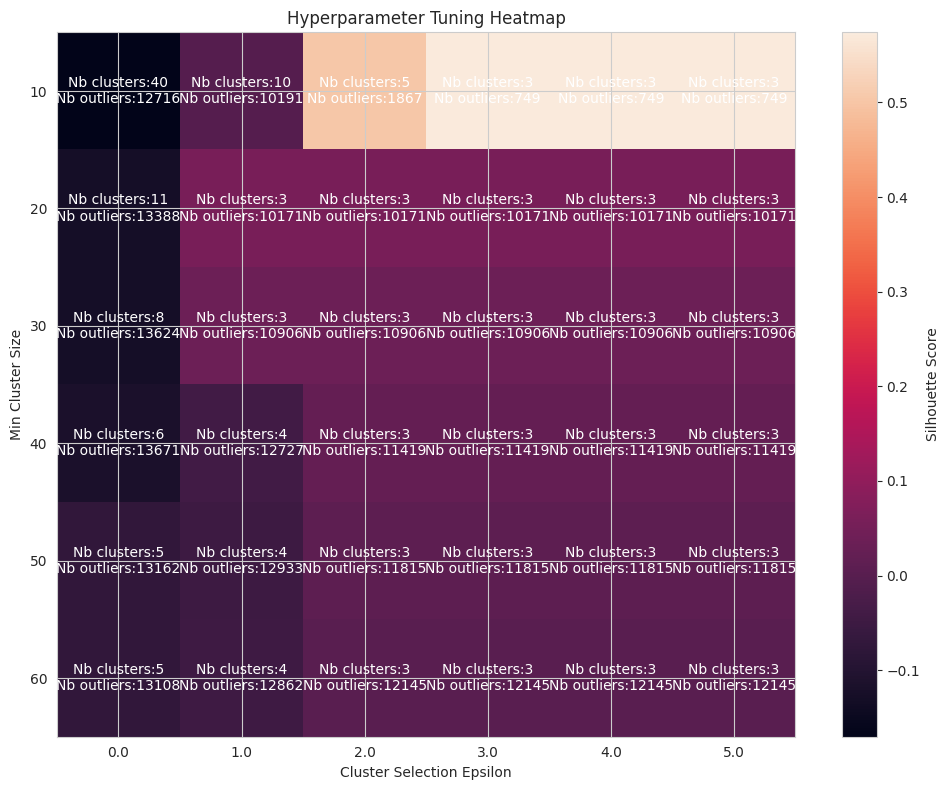

In [246]:
# Plot the hyperparameter heatmap
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

Model fitted. Num of clusters found: 4
Labels and probabilities added


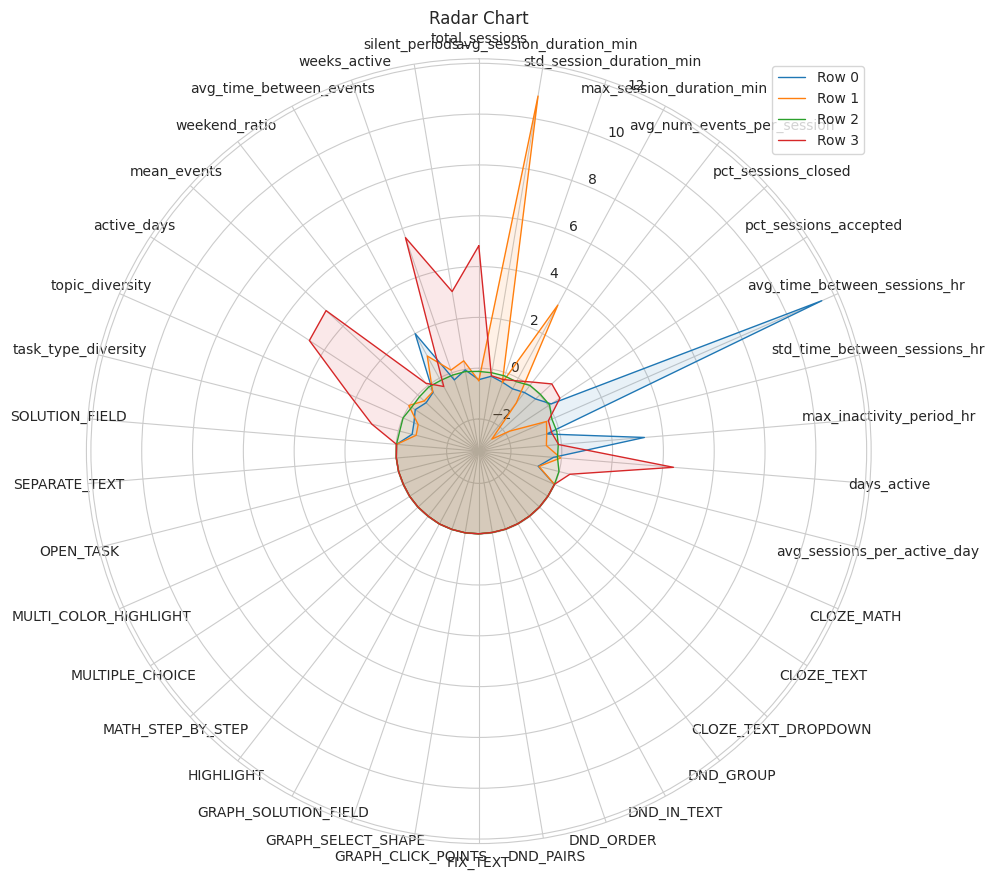

In [249]:
# Fit the data and plot the centroids
without_preferred_clusters5, without_preferred_clusters_centroids5 = init_fit_hdbscan_clustering(X_without_preferred, min_cluster_size=10, cluster_selection_epsilon=2.0)
create_radar_chart(without_preferred_clusters_centroids5)

In [250]:
# Count the number of samples in each cluster
without_preferred_clusters5['labels'].value_counts()

labels
 2    17014
-1     1867
 3       41
 1       12
 0       11
Name: count, dtype: int64

Model fitted. Num of clusters found: 2
Labels and probabilities added


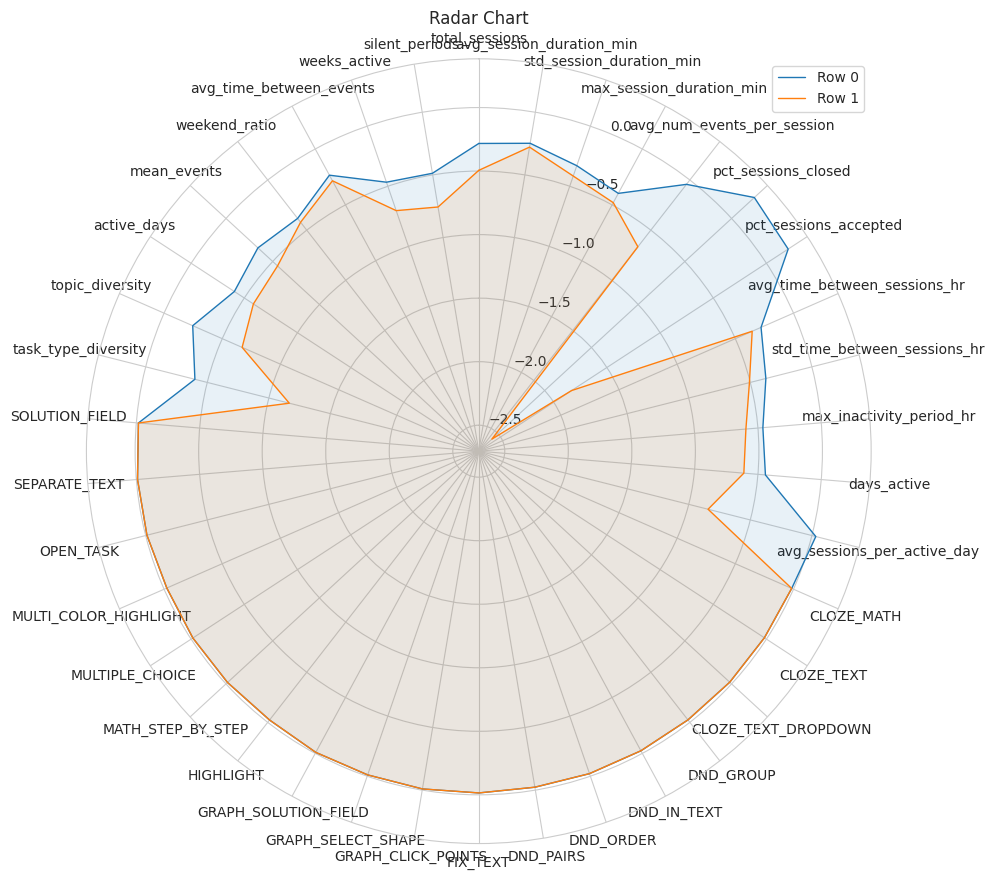

In [252]:
# Fit the data and plot the centroids
without_preferred_clusters3, without_preferred_clusters3_centroids = init_fit_hdbscan_clustering(X_without_preferred, min_cluster_size=20, cluster_selection_epsilon=1.0)
create_radar_chart(without_preferred_clusters3_centroids)

In [253]:
# Count the number of samples in each cluster
without_preferred_clusters3['labels'].value_counts()

labels
-1    10171
 0     7630
 1     1144
Name: count, dtype: int64

#### Analysis
HDBSCAN did separate some clusters. However, the clusterer often follows the same pattern: it puts all the 'standard' samples in one big cluster, declare some outliers and put small groups of quite similar outliers in some other clusters. This is not really what we are looking for. An hypothesis would be that we are clustering on too many features. Considering the curse of dimensionality, this can give a hard time to the clusterer.

## For session-based features
As said before, the curse of dimensionality could worsen the clusterer. Let's then fit HDBSCAN on the themed features computed before. Namely : session features performance features, temporal features and consistency features.

In [254]:
session_df = final_session_features.drop(columns=['user_id'])
user_ids_session = final_session_features['user_id']
#re drop features that where dropped in the original feature selection
columns_to_drop = [
    'min_session_duration_min',
    'median_session_duration_min'
]
session_df.drop(columns=columns_to_drop, inplace=True)
# Remove very low-variance features (threshold = 0.01 is common)
selector = VarianceThreshold(threshold=0.01)
session_features_selected = selector.fit_transform(session_df)
session_column_selected = session_df.columns[selector.get_support()]
session_df = pd.DataFrame(session_features_selected, columns=session_column_selected)

session_scaled_df = scaler.fit_transform(session_df)
session_scaled_df = pd.DataFrame(session_scaled_df, columns=session_df.columns)


In [255]:
# Initialize the parameters to be tuned
min_cluster_size_list = [10, 20, 30, 40]
cluster_selection_epsilon_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(session_scaled_df, min_cluster_size_list, cluster_selection_epsilon_list)

For min_cluster_size=10 and cluster_selection_epsilon=0.0:
	Nb clusters: 152
	Nb outliers: 15002
	Silhouette score: -0.339502399688445
For min_cluster_size=10 and cluster_selection_epsilon=1.0:
	Nb clusters: 7
	Nb outliers: 2793
	Silhouette score: 0.1892491510647844
For min_cluster_size=10 and cluster_selection_epsilon=2.0:
	Nb clusters: 3
	Nb outliers: 310
	Silhouette score: 0.6541428643737165
For min_cluster_size=10 and cluster_selection_epsilon=3.0:
	Nb clusters: 3
	Nb outliers: 310
	Silhouette score: 0.6541428643737165
For min_cluster_size=10 and cluster_selection_epsilon=4.0:
	Nb clusters: 3
	Nb outliers: 310
	Silhouette score: 0.6541428643737165
For min_cluster_size=10 and cluster_selection_epsilon=5.0:
	Nb clusters: 3
	Nb outliers: 310
	Silhouette score: 0.6541428643737165
-----------------------------------
For min_cluster_size=20 and cluster_selection_epsilon=0.0:
	Nb clusters: 62
	Nb outliers: 14783
	Silhouette score: -0.2500919142451847
For min_cluster_size=20 and cluster_se

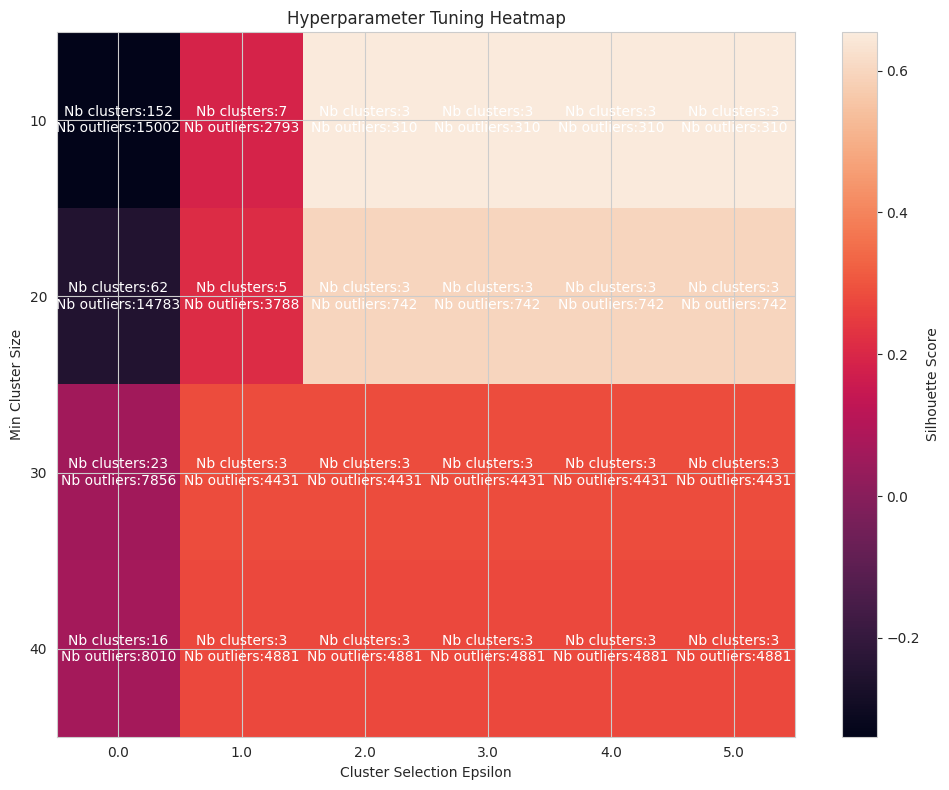

In [256]:
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

Model fitted. Num of clusters found: 4
Labels and probabilities added


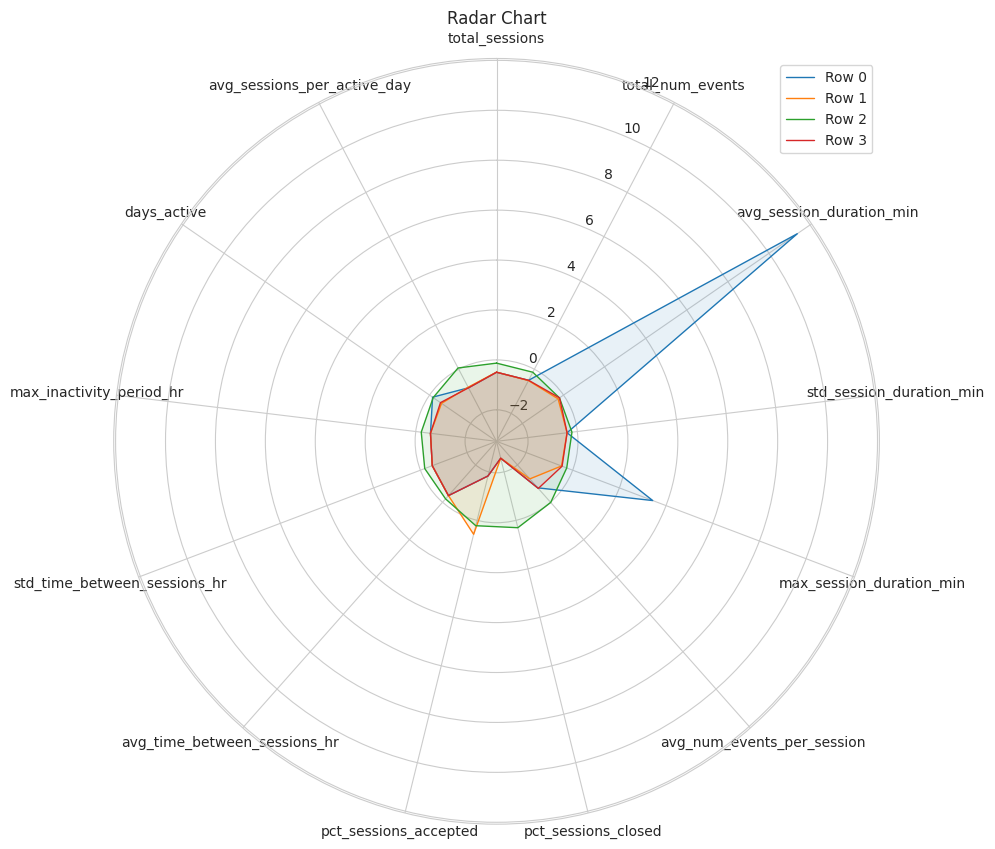

In [257]:
session_clusters5, session_clusters5_centroids = init_fit_hdbscan_clustering(session_scaled_df, min_cluster_size=20, cluster_selection_epsilon=1.0)
create_radar_chart(session_clusters5_centroids)

In [258]:
session_clusters5['labels'].value_counts()

labels
 2    13921
-1     3788
 3     1866
 0       29
 1       26
Name: count, dtype: int64

Model fitted. Num of clusters found: 2
Labels and probabilities added


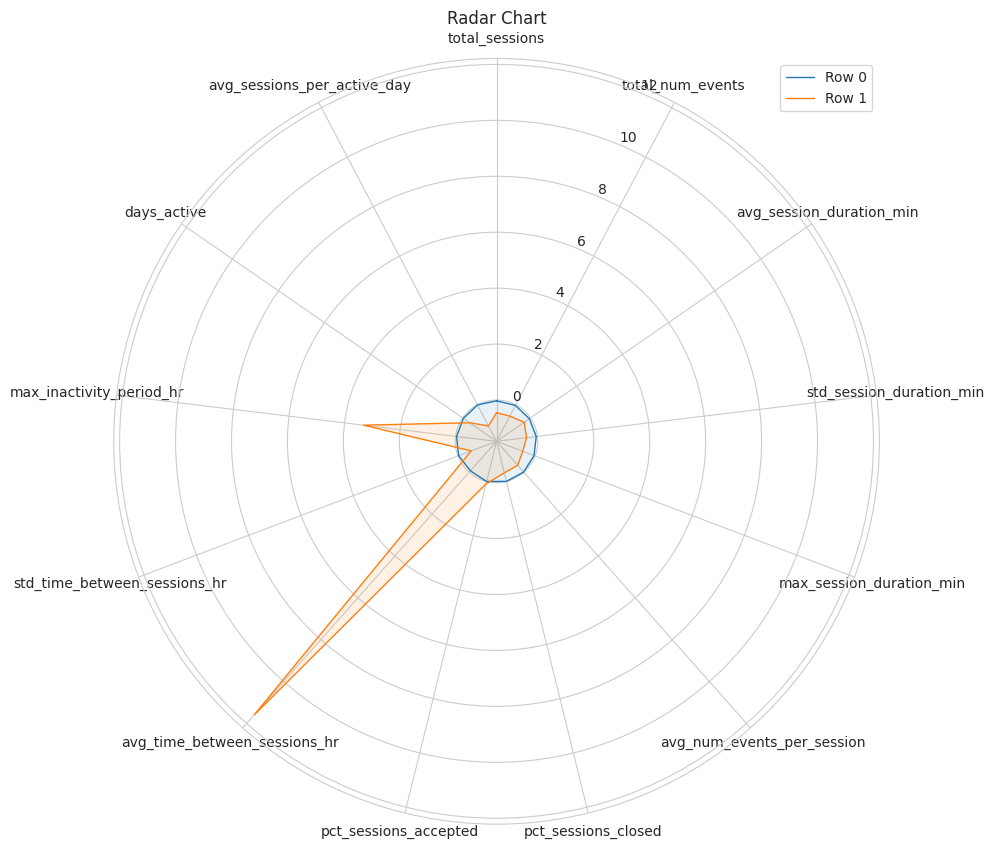

In [259]:
session_clusters3, session_clusters3_centroids = init_fit_hdbscan_clustering(session_scaled_df, min_cluster_size=10, cluster_selection_epsilon=2.0)
create_radar_chart(session_clusters3_centroids)

In [260]:
session_clusters3['labels'].value_counts()

labels
 0    19310
-1      310
 1       10
Name: count, dtype: int64

#### Analysis
The same pattern occured. The most of the samples are inside a big cluster and the outliers are sometimes in small groups...
However, the model still found a quite interesting cluster. One of the five clusters the clusterer found contains a non negligible number of people who tends to have some smaller values for the ensemble of the features, particularly for the percentage of closed et accepted sessions.

## For Transaction Features

In [261]:
performance_df = performance_features.drop(columns=['user_id'])
user_ids_performance = performance_features['user_id']
performance_df = process_features(performance_df)

# Initialize the parameters to be tuned
min_cluster_size_list = [10, 20, 30, 40]
cluster_selection_epsilon_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(performance_df, min_cluster_size_list, cluster_selection_epsilon_list)


For min_cluster_size=10 and cluster_selection_epsilon=0.0:
	Nb clusters: 488
	Nb outliers: 3239
	Silhouette score: 0.6687302323078881
For min_cluster_size=10 and cluster_selection_epsilon=1.0:
	Nb clusters: 12
	Nb outliers: 258
	Silhouette score: 0.4912617529892101
For min_cluster_size=10 and cluster_selection_epsilon=2.0:
	Nb clusters: 12
	Nb outliers: 258
	Silhouette score: 0.4912617529892101
For min_cluster_size=10 and cluster_selection_epsilon=3.0:
	Nb clusters: 9
	Nb outliers: 189
	Silhouette score: 0.50218913617403
For min_cluster_size=10 and cluster_selection_epsilon=4.0:
	Nb clusters: 9
	Nb outliers: 189
	Silhouette score: 0.50218913617403
For min_cluster_size=10 and cluster_selection_epsilon=5.0:
	Nb clusters: 7
	Nb outliers: 183
	Silhouette score: 0.4468070962310249
-----------------------------------
For min_cluster_size=20 and cluster_selection_epsilon=0.0:
	Nb clusters: 299
	Nb outliers: 4837
	Silhouette score: 0.48992899737517165
For min_cluster_size=20 and cluster_select

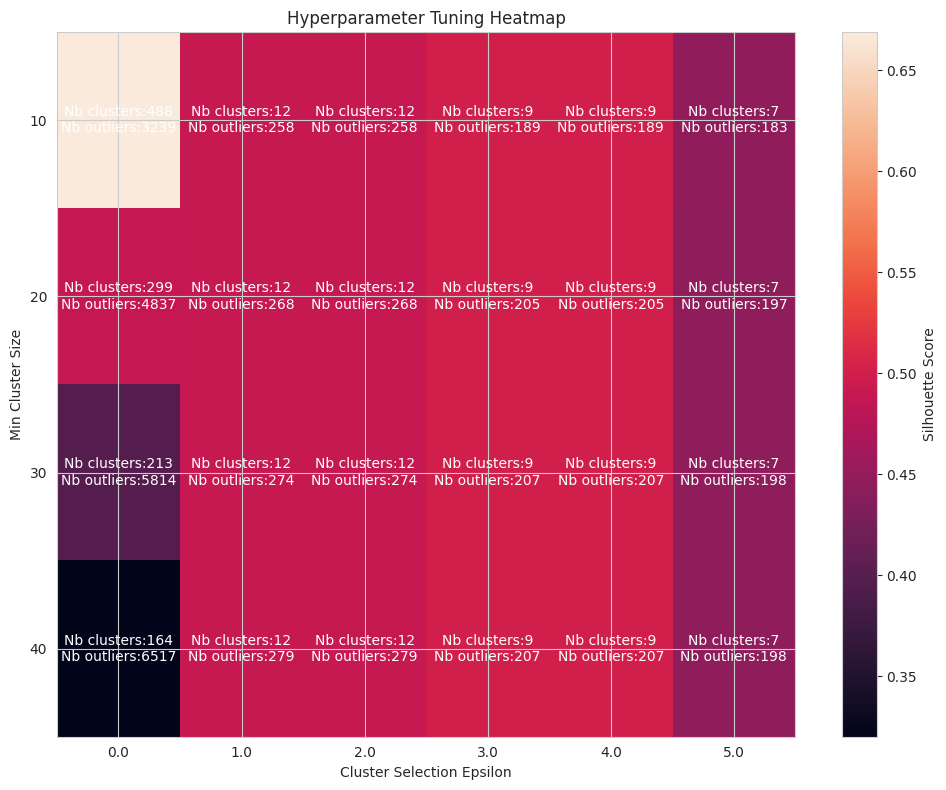

In [262]:
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

Model fitted. Num of clusters found: 8
Labels and probabilities added


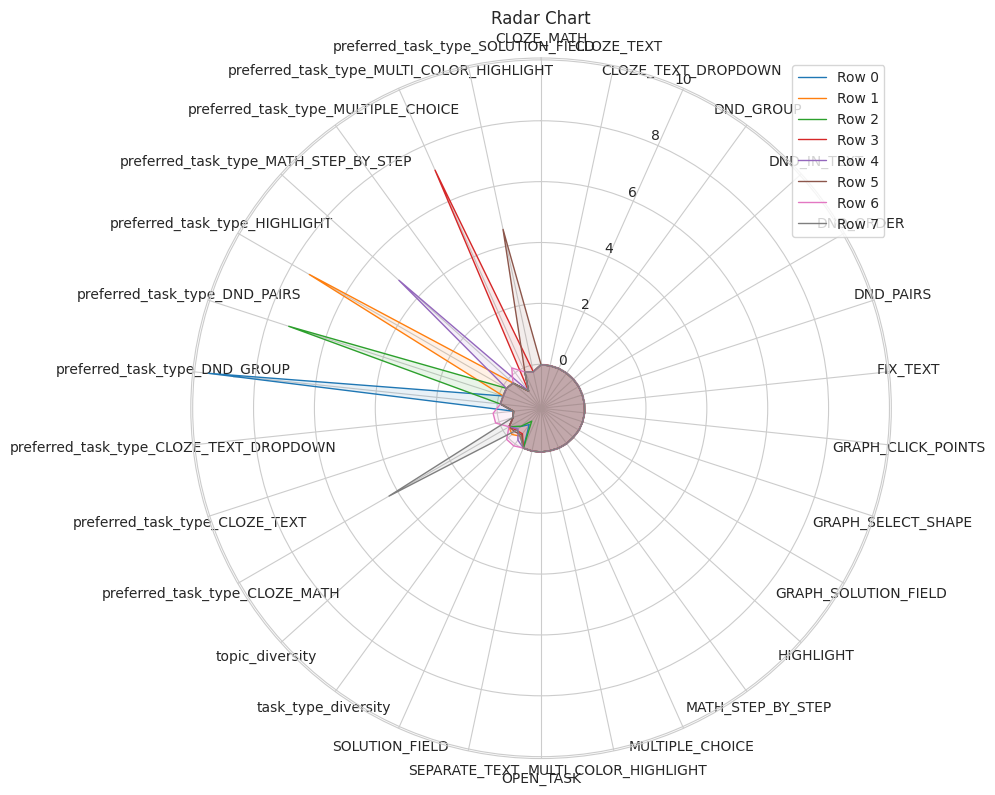

In [263]:
performance_clusters9, performance_clusters9_centroids = init_fit_hdbscan_clustering(performance_df, min_cluster_size=10, cluster_selection_epsilon=3.0)
create_radar_chart(performance_clusters9_centroids)

In [264]:
performance_clusters9['labels'].value_counts()

labels
 6    16906
 7     1077
 5      973
 4      870
 3      410
 2      391
 1      387
 0      231
-1      189
Name: count, dtype: int64

#### Analysis
No surprise here, the results are even worse since this set contains some binary values. However, the clusters contains more sample than previously which is a good beginning.

## Using Temporal Features

In [265]:
temporal_df = temporal_final_clean.drop(columns=['user_id'])
user_ids_temporal = temporal_final_clean['user_id']
temporal_df = process_features(temporal_df)

# Initialize the parameters to be tuned
min_cluster_size_list = [10, 30, 50, 70]
cluster_selection_epsilon_list = [0.0, 0.5, 1.0, 1.5, 2.0]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(temporal_df, min_cluster_size_list, cluster_selection_epsilon_list)

For min_cluster_size=10 and cluster_selection_epsilon=0.0:
	Nb clusters: 222
	Nb outliers: 10846
	Silhouette score: -0.3236068395545906
For min_cluster_size=10 and cluster_selection_epsilon=0.5:
	Nb clusters: 3
	Nb outliers: 2636
	Silhouette score: 0.3778855573284578
For min_cluster_size=10 and cluster_selection_epsilon=1.0:
	Nb clusters: 3
	Nb outliers: 2636
	Silhouette score: 0.3778855573284578
For min_cluster_size=10 and cluster_selection_epsilon=1.5:
	Nb clusters: 3
	Nb outliers: 2636
	Silhouette score: 0.3778855573284578
For min_cluster_size=10 and cluster_selection_epsilon=2.0:
	Nb clusters: 3
	Nb outliers: 2636
	Silhouette score: 0.3778855573284578
-----------------------------------
For min_cluster_size=30 and cluster_selection_epsilon=0.0:
	Nb clusters: 18
	Nb outliers: 12225
	Silhouette score: -0.2622625881026095
For min_cluster_size=30 and cluster_selection_epsilon=0.5:
	Nb clusters: 3
	Nb outliers: 3891
	Silhouette score: 0.5458800518642958
For min_cluster_size=30 and clust

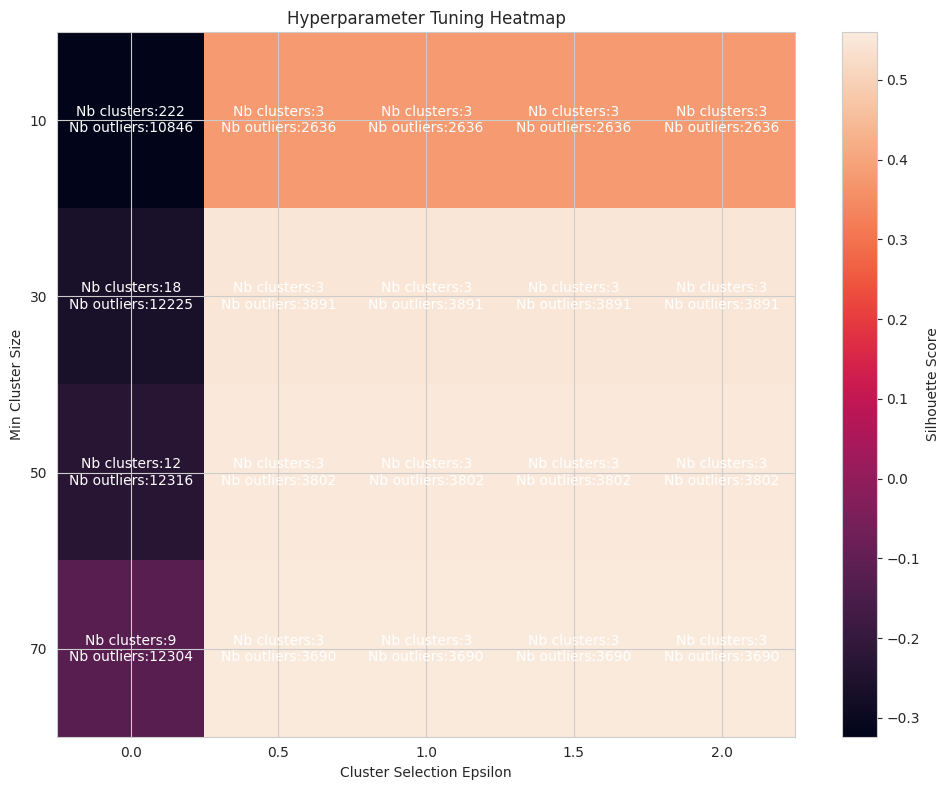

In [266]:
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

Model fitted. Num of clusters found: 2
Labels and probabilities added


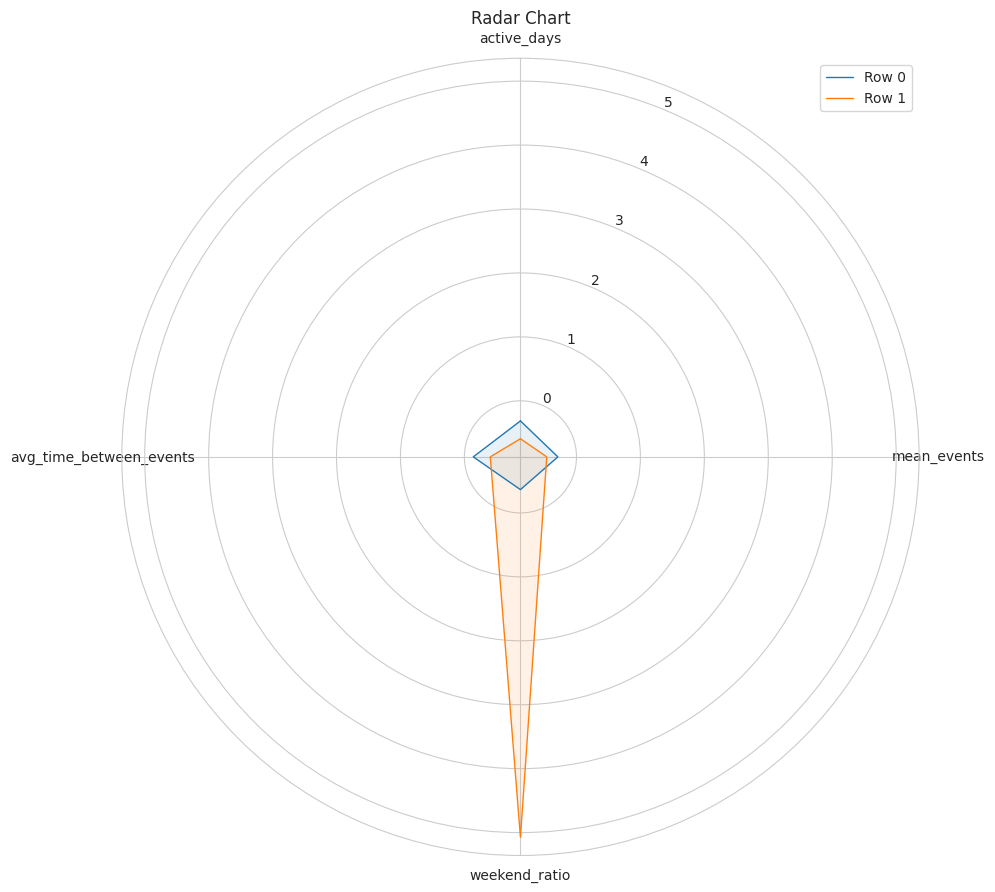

In [270]:
temporal_clusters3, temporal_clusters3_centroids = init_fit_hdbscan_clustering(temporal_df, min_cluster_size=70, cluster_selection_epsilon=0.5)
create_radar_chart(temporal_clusters3_centroids)

In [272]:
temporal_clusters3['labels'].value_counts()

labels
 0    18613
-1     3690
 1      167
Name: count, dtype: int64

#### Analysis
Again the same...

## Using consistency features

In [273]:
consistency_df = consistency_features.drop(columns=['user_id'])
user_ids_consistency = consistency_features['user_id']
consistency_df = process_features(consistency_df)

# Initialize the parameters to be tuned
min_cluster_size_list = [10, 30, 50, 70]
cluster_selection_epsilon_list = [0.0, 0.5, 1.0, 1.5, 2.0]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(consistency_df, min_cluster_size_list, cluster_selection_epsilon_list)

For min_cluster_size=10 and cluster_selection_epsilon=0.0:
	Nb clusters: 102
	Nb outliers: 264
	Silhouette score: 0.9695343250221271
For min_cluster_size=10 and cluster_selection_epsilon=0.5:
	Nb clusters: 3
	Nb outliers: 105
	Silhouette score: 0.7673873864516039
For min_cluster_size=10 and cluster_selection_epsilon=1.0:
	Nb clusters: 3
	Nb outliers: 105
	Silhouette score: 0.7673873864516039
For min_cluster_size=10 and cluster_selection_epsilon=1.5:
	Nb clusters: 3
	Nb outliers: 105
	Silhouette score: 0.7673873864516039
For min_cluster_size=10 and cluster_selection_epsilon=2.0:
	Nb clusters: 3
	Nb outliers: 105
	Silhouette score: 0.7673873864516039
-----------------------------------
For min_cluster_size=30 and cluster_selection_epsilon=0.0:
	Nb clusters: 58
	Nb outliers: 639
	Silhouette score: 0.928322115639077
For min_cluster_size=30 and cluster_selection_epsilon=0.5:
	Nb clusters: 3
	Nb outliers: 139
	Silhouette score: 0.7657066946622053
For min_cluster_size=30 and cluster_selection

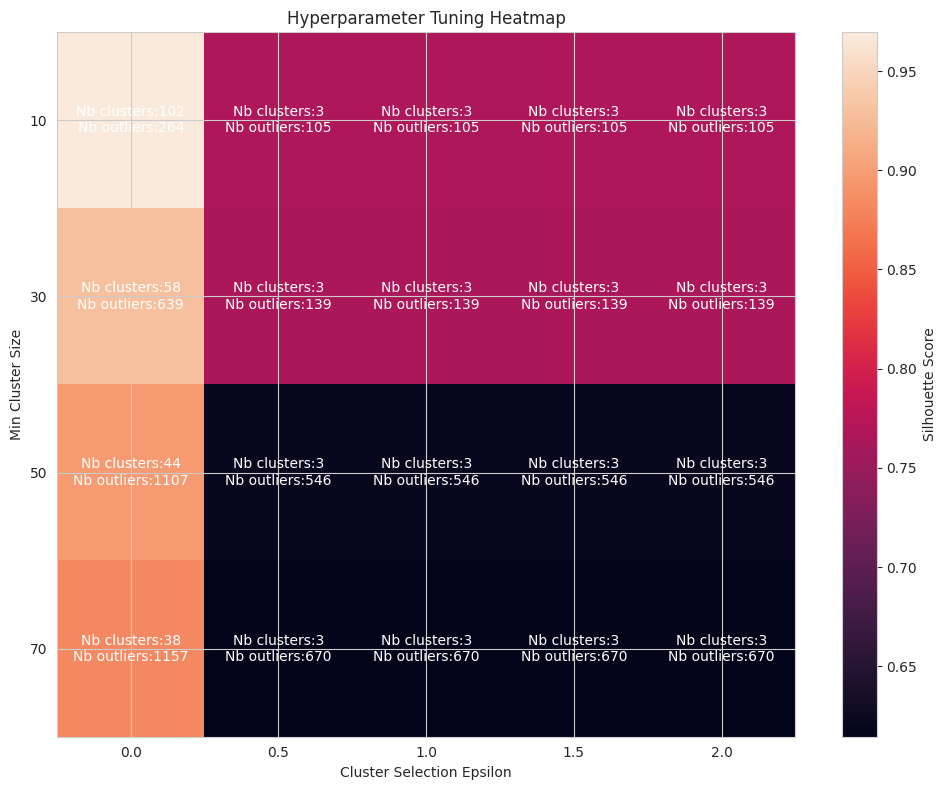

In [274]:
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

In [275]:
# consistency only has 2 features, so radar chart is not great, we will use scatterplots instead.
consistency_df.head()

weeks_active  silent_periods
0      8.649997        6.477566
1      6.354716        8.630960
2      9.415091        6.908245
3     -0.021065        0.448063
4      0.999060        0.878742

Model fitted. Num of clusters found: 2
Labels and probabilities added


[Text(0.5, 1.0, 'cluster distribution for consistency features')]

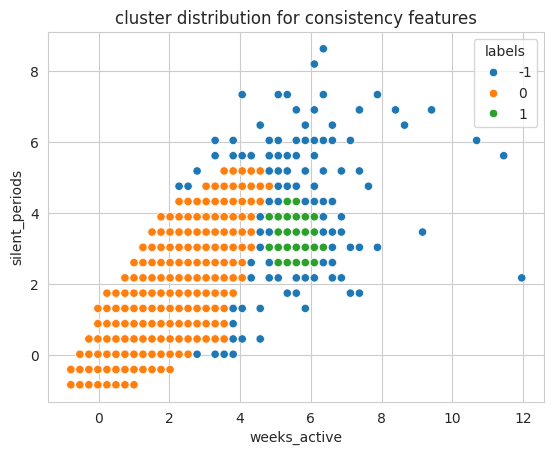

In [276]:
consistency_clusters3, consistency_clusters3_centroids = init_fit_hdbscan_clustering(consistency_df, min_cluster_size=20, cluster_selection_epsilon=1.0)
sns.scatterplot(x = 'weeks_active', y='silent_periods', hue='labels', data = consistency_clusters3.drop('probabilities', axis=1), palette = 'tab10').set(title='cluster distribution for consistency features')

In [278]:
consistency_clusters3['labels'].value_counts()

labels
 0    22270
-1      136
 1       64
Name: count, dtype: int64

In [279]:
consistency_clusters76, consistency_clusters76_centroids = init_fit_hdbscan_clustering(consistency_df, min_cluster_size=20, cluster_selection_epsilon=0.0)

Model fitted. Num of clusters found: 73
Labels and probabilities added


/tmp/ipykernel_6160/1496467413.py:2: UserWarning: 
The palette list has fewer values (25) than needed (74) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x = 'weeks_active', y='silent_periods', hue='labels', data = consistency_clusters76.drop('probabilities', axis=1), palette=custom_palette).set(title='cluster distribution for consistency features')


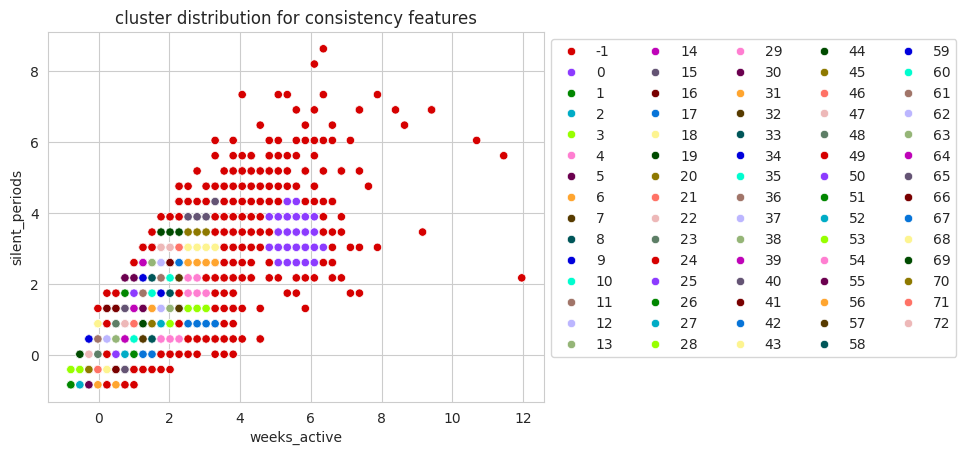

In [280]:
custom_palette = sns.color_palette(cc.glasbey, n_colors=25)
sns.scatterplot(x = 'weeks_active', y='silent_periods', hue='labels', data = consistency_clusters76.drop('probabilities', axis=1), palette=custom_palette).set(title='cluster distribution for consistency features')
plt.legend(ncol=5, bbox_to_anchor=(1, 1))
plt.show()

In [281]:
consistency_clusters76['labels'].value_counts()

labels
1     5355
3     3312
22    1734
20    1347
2     1236
      ... 
67      23
43      23
71      21
9       20
53      20
Name: count, Length: 74, dtype: int64

#### Analysis
The model is again not finding really meaningful clusters. We can see that the cluster 1 from the case with 3 cluster is still there, but the big cluster is now split into a lot of sub-clusters.

# Reducing the number of features, PCA approach
We saw previously that the curse of dimensionality is quite annoying. We need to reduce the dimensionality of our set by a meaningful manner. A good way to do this is PCA. We will use PCA to get the principal components of our data and use only the most meaningful ones.

In [282]:
# Declare the model and fit our data
pca = PCA()
pca_result = pca.fit_transform(X_scaled_final_clustering)

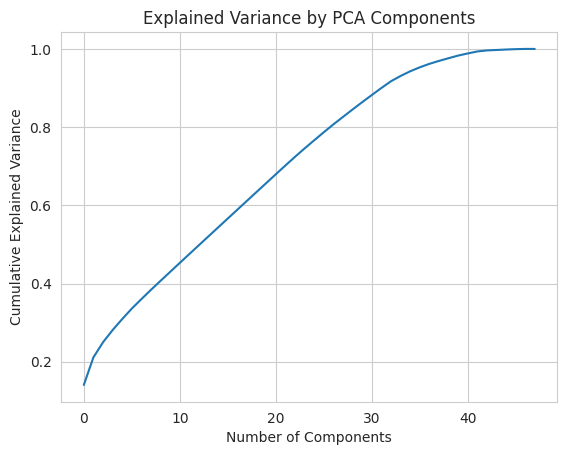

In [283]:
# Plot the variance by PCA components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

No elbow, needs around 25 components t explain 80% of the variance, approx. linear until 30 components then get a bit more flat => clustering on the 30 PC to get rid of a few features

In [284]:
# We load the principal components composition
loadings = pd.DataFrame(
    pca.components_.T,  # shape: [n_features, n_components]
    columns=[f'PC{i+1}' for i in range(X_scaled_final_clustering.shape[1])],
    index=X_scaled_final_clustering.columns
)

In [285]:
loadings

PC1       PC2       PC3  \
total_sessions                             0.281135 -0.197451 -0.008241   
avg_session_duration_min                   0.040388  0.321418 -0.140163   
std_session_duration_min                   0.120222  0.408354  0.046126   
max_session_duration_min                   0.175226  0.363392  0.019707   
avg_num_events_per_session                 0.041955 -0.061378  0.222463   
pct_sessions_closed                        0.143210 -0.085293  0.398929   
pct_sessions_accepted                      0.135670 -0.065792  0.447069   
avg_time_between_sessions_hr               0.076604  0.361730  0.091214   
std_time_between_sessions_hr               0.143035  0.366945  0.191557   
max_inactivity_period_hr                   0.206603  0.327196  0.194331   
days_active                                0.331471 -0.075561 -0.253287   
avg_sessions_per_active_day                0.102292 -0.197325  0.363073   
CLOZE_MATH                                 0.001131  0.041773 -0.004577   
CLOZE_TEXT                                 0.007809  0.049239 -0.054841   
CLOZE_TEXT_DROPDOWN                        0.001051  0.051480 -0.027648   
DND_GROUP                                  0.005243  0.016565  0.008184   
DND_IN_TEXT                                0.007092  0.008391  0.010172   
DND_ORDER                                  0.000768  0.004458  0.011176   
DND_PAIRS                                 -0.002284  0.043458 -0.066359   
FIX_TEXT                                   0.009548  0.012891  0.007172   
GRAPH_CLICK_POINTS                         0.008215  0.000698  0.008782   
GRAPH_SELECT_SHAPE                         0.000691  0.010091  0.020364   
GRAPH_SOLUTION_FIELD                       0.002101  0.008874  0.012596   
HIGHLIGHT                                  0.004710  0.031769 -0.027488   
MATH_STEP_BY_STEP                          0.007511  0.009670 -0.017601   
MULTIPLE_CHOICE                           -0.000966  0.026830 -0.009985   
MULTI_COLOR_HIGHLIGHT                      0.003905  0.046298 -0.028534   
OPEN_TASK                                 -0.002123  0.020894 -0.022626   
SEPARATE_TEXT                              0.000476  0.004115  0.004140   
SOLUTION_FIELD                             0.004333  0.058873  0.009396   
task_type_diversity                        0.280061 -0.068601  0.178727   
topic_diversity                            0.285477 -0.140891  0.120791   
preferred_task_type_CLOZE_MATH            -0.019031  0.021610 -0.081070   
preferred_task_type_CLOZE_TEXT            -0.012885 -0.033975 -0.055784   
preferred_task_type_CLOZE_TEXT_DROPDOWN    0.042121 -0.047031  0.097327   
preferred_task_type_DND_GROUP             -0.023008  0.009436 -0.049037   
preferred_task_type_DND_PAIRS             -0.048509  0.014606 -0.142786   
preferred_task_type_HIGHLIGHT             -0.007386 -0.000187  0.004069   
preferred_task_type_MATH_STEP_BY_STEP     -0.008582  0.010862 -0.082740   
preferred_task_type_MULTIPLE_CHOICE        0.026877  0.044579  0.113771   
preferred_task_type_MULTI_COLOR_HIGHLIGHT -0.003062  0.013656 -0.021907   
preferred_task_type_SOLUTION_FIELD        -0.022664 -0.005768 -0.038318   
active_days                                0.347894 -0.079305 -0.265837   
mean_events                                0.343710 -0.184669 -0.099377   
weekend_ratio                              0.074387 -0.056779  0.030079   
avg_time_between_events                   -0.015906  0.172540 -0.078262   
weeks_active                               0.355046 -0.030840 -0.231607   
silent_periods                             0.325915  0.060536 -0.165124   

                                                PC4       PC5       PC6  \
total_sessions                             0.009055  0.191852 -0.026972   
avg_session_duration_min                  -0.098707  0.323138 -0.191943   
std_session_duration_min                  -0.079653  0.218782 -0.118095   
max_session_duration_min                  -0.062971  0.277668 -0.141474 

In [286]:
# We apply PCA with 30 components on our dataset
pca30 = PCA(n_components=30)
pca30_result = pca30.fit_transform(X_scaled_final_clustering)

In [287]:
pca30_result

array([[ 1.75686617e+01, -1.82496657e+00, -8.68028735e+00, ...,
         3.97439026e-01, -1.18893196e+00,  9.77343741e-01],
       [ 1.45018021e+01, -1.66477236e-01, -4.79851587e+00, ...,
        -2.23184657e+00, -2.68873994e+00,  3.16382712e+00],
       [ 1.48053078e+01, -1.03473705e+00, -7.54673568e+00, ...,
         4.17062500e-01, -9.24794515e-01,  8.51424322e-01],
       ...,
       [-2.08989243e+00, -4.59576960e-01,  7.77040827e-01, ...,
         1.97218101e-01, -2.09299892e-01,  1.37249158e-01],
       [-2.79172442e+00, -9.50157421e-02, -1.22737563e+00, ...,
         1.52831976e-02, -1.11184902e-01, -3.99922157e-01],
       [-2.41476604e+00, -4.94390304e-01, -1.47065725e-01, ...,
        -3.89036242e-01, -3.07009049e-01,  2.84136644e-01]],
      shape=(18945, 30))

In [288]:
# Initialize the parameters to be tuned
min_cluster_size_list = [10, 30, 50, 70]
cluster_selection_epsilon_list = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(pca30_result, min_cluster_size_list, cluster_selection_epsilon_list)

For min_cluster_size=10 and cluster_selection_epsilon=0.0:
	Nb clusters: 29
	Nb outliers: 9412
	Silhouette score: -0.12473497778914544
For min_cluster_size=10 and cluster_selection_epsilon=2.0:
	Nb clusters: 7
	Nb outliers: 477
	Silhouette score: 0.22887369918829614
For min_cluster_size=10 and cluster_selection_epsilon=4.0:
	Nb clusters: 6
	Nb outliers: 360
	Silhouette score: 0.2178271046959167
For min_cluster_size=10 and cluster_selection_epsilon=6.0:
	Nb clusters: 4
	Nb outliers: 203
	Silhouette score: 0.3358000638378246
For min_cluster_size=10 and cluster_selection_epsilon=8.0:
	Nb clusters: 3
	Nb outliers: 173
	Silhouette score: 0.36252694337103203
For min_cluster_size=10 and cluster_selection_epsilon=10.0:
	Nb clusters: 3
	Nb outliers: 173
	Silhouette score: 0.36252694337103203
-----------------------------------
For min_cluster_size=30 and cluster_selection_epsilon=0.0:
	Nb clusters: 11
	Nb outliers: 3855
	Silhouette score: 0.10202194185917941
For min_cluster_size=30 and cluster_

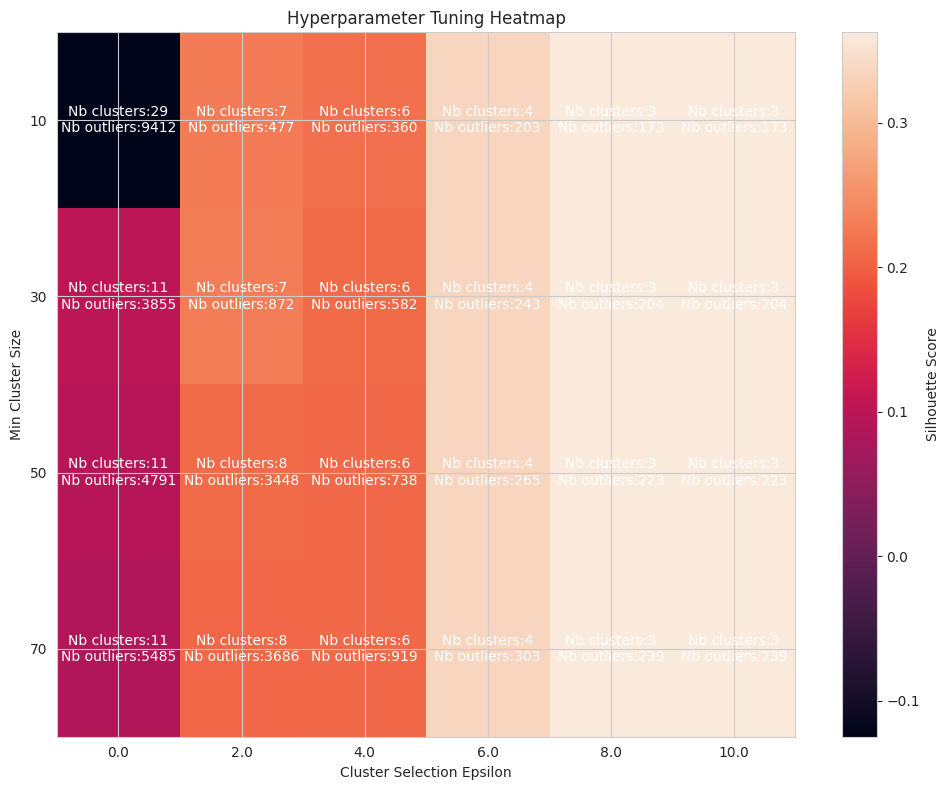

In [289]:
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

In [290]:
pca30_result_df = pd.DataFrame(pca30_result.T, [f'PC{i+1}' for i in np.arange(30)]).T
pca30_result_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      17.568662 -1.824967 -8.680287 -0.682837 -1.184169  1.421992  0.614106   
1      14.501802 -0.166477 -4.798516  0.225689  0.076235 -0.158278 -0.304795   
2      14.805308 -1.034737 -7.546736  1.737444 -3.520687  0.009792  0.818418   
3      -1.039562  0.482279 -0.982466  0.452156 -0.548276  0.720506  0.041815   
4       0.163818 -0.654556 -0.606964  1.097269 -1.054265 -0.624328  0.267846   
...          ...       ...       ...       ...       ...       ...       ...   
18940  -2.476876 -0.391080 -0.548346  1.886486  0.455417 -0.345201  0.084764   
18941  -2.661090 -0.142660 -0.648177  1.703650 -0.109329 -0.324927  0.180963   
18942  -2.089892 -0.459577  0.777041  1.361716 -0.247390 -0.615790  0.151353   
18943  -2.791724 -0.095016 -1.227376  1.937521  0.224895 -0.209639  0.131643   
18944  -2.414766 -0.494390 -0.147066 -0.096036  0.050186  0.175823 -0.147894   

            PC8       PC9      PC10  ...      PC21      PC22      PC23  \
0     -1.981917  0.983598 -0.833872  ...  0.666937 -0.240185 -1.467577   
1     -0.833062 -0.164106 -0.894622  ...  0.210842 -0.209199 -0.001947   
2     -1.900927  1.153319 -0.758968  ...  0.299494 -0.450982 -1.434103   
3     -0.216349 -0.284405  0.206465  ...  0.217992 -0.035852  0.308334   
4     -0.777494  0.637928 -0.275416  ... -0.027641 -0.127923 -0.760642   
...         ...       ...       ...  ...       ...       ...       ...   
18940  0.156615 -0.247906  0.043861  ... -0.142136  0.228921 -0.035677   
18941 -0.172676  0.023718 -0.069213  ... -0.103303  0.112978 -0.281098   
18942 -0.383098  0.315835 -0.054145  ... -0.109805 -0.007465 -0.460319   
18943  0.062358 -0.233582 -0.007552  ... -0.114152  0.240882 -0.083066   
18944 -0.403996 -0.079311  0.256441  ...  0.135023  0.080170  0.065631   

           PC24      PC25      PC26      PC27      PC28      PC29      PC30  
0      1.672439 -1.138988  0.069292 -1.395123  0.397439 -1.188932  0.977344  
1      1.142138 -0.481957  0.452463  1.336593 -2.231847 -2.688740  3.163827  
2      2.281012 -0.393380  0.741139 -1.273717  0.417063 -0.924795  0.851424  
3      0.325879  0.254681  0.361872  0.621185 -0.465160 -0.279106  0.052100  
4      1.034895 -0.267607  0.401411 -0.430614 -0.028157  0.076410  0.072393  
...         ...       ...       ...       ...       ...       ...       ...  
18940 -0.622469 -0.029664 -0.384527 -0.223753  0.050725 -0.136307 -0.305882  
18941 -0.169988 -0.082490 -0.198028 -0.343981  0.036063 -0.141802 -0.148999  
18942  0.259025 -0.105154  0.042750 -0.336018  0.197218 -0.209300  0.137249  
18943 -0.611298 -0.062857 -0.417541 -0.321087  0.015283 -0.111185 -0.399922  
18944  0.376368 -0.061202  0.142235  0.454305 -0.389036 -0.307009  0.284137  

[18945 rows x 30 columns]

Model fitted. Num of clusters found: 4
Labels and probabilities added


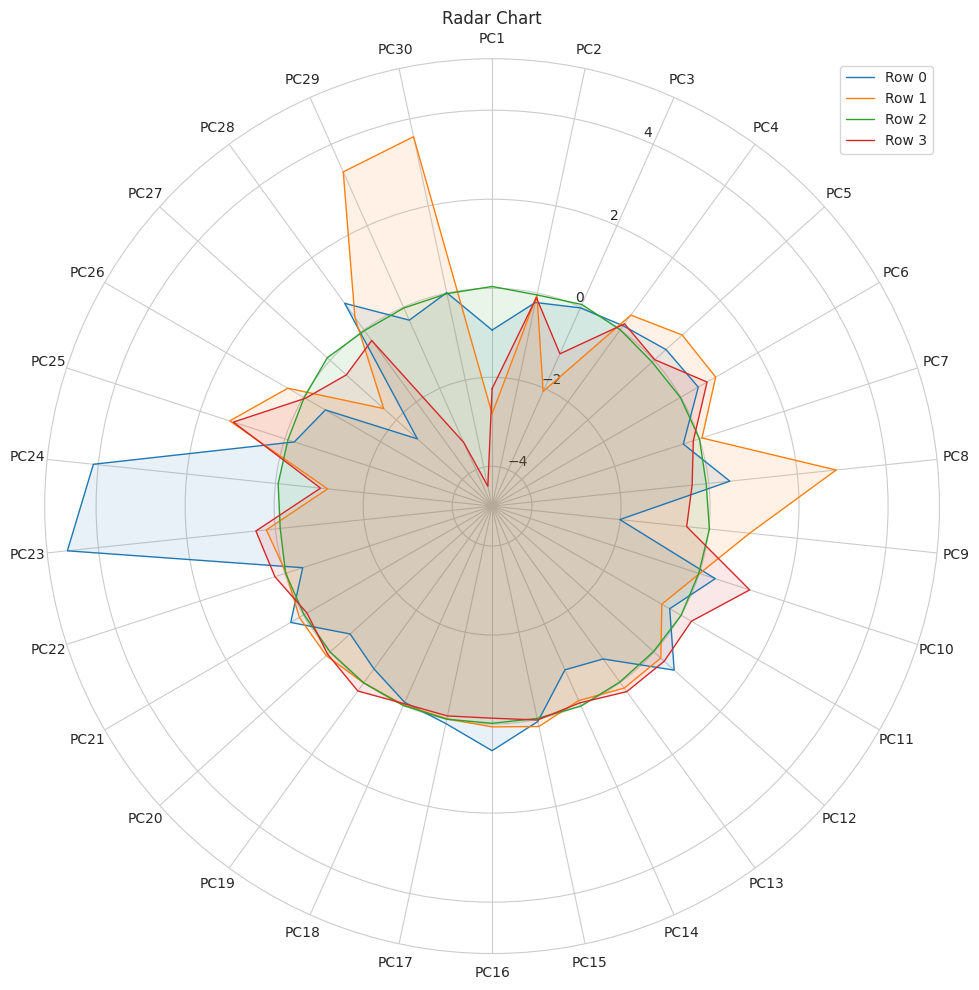

In [291]:
pca30_clusters5, pca30_clusters5_centroids = init_fit_hdbscan_clustering(pca30_result_df, min_cluster_size=10, cluster_selection_epsilon=5.0)
# consistency only has 2 features, so radar chart is not great
create_radar_chart(pca30_clusters5_centroids)

In [292]:
pca30_clusters5['labels'].value_counts()

labels
 2    17815
 0      358
 1      341
-1      251
 3      180
Name: count, dtype: int64

#### Analysis
This clustering seems more interesting. It appears that the PCA did generalize the binary features, most likely because those were highly correlated. However, the cluster sizes are still really low and after looking at the representation of the component compositions, the binary features problem is still present. For example, cluster 0, PC23 and PC24 are high and these two components are mainly determined by 'preferred_task_type_HIGHLIGHT'.

### Custom features
Let's now try to take some well chosen features. We emitted this hypothesis: 'People working during the weekend tends to be hard workers, hence have more active days and spend more time on a session.' We will try to validate or reject it by clustering those features.

In [293]:
X_custom = X_scaled_final_clustering[['active_days', 'weekend_ratio', 'avg_sessions_per_active_day', 'topic_diversity', 'avg_session_duration_min']]

In [295]:
# Initialize the parameters to be tuned
min_cluster_size_list = [10, 30, 50, 70]
cluster_selection_epsilon_list = [0.15, 0.2, 0.25, 0.3]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(X_custom, min_cluster_size_list, cluster_selection_epsilon_list)

For min_cluster_size=10 and cluster_selection_epsilon=0.15:
	Nb clusters: 44
	Nb outliers: 9579
	Silhouette score: -0.2634099731234547
For min_cluster_size=10 and cluster_selection_epsilon=0.2:
	Nb clusters: 27
	Nb outliers: 8886
	Silhouette score: -0.2431076313392956
For min_cluster_size=10 and cluster_selection_epsilon=0.25:
	Nb clusters: 13
	Nb outliers: 7691
	Silhouette score: -0.1199118232032359
For min_cluster_size=10 and cluster_selection_epsilon=0.3:
	Nb clusters: 8
	Nb outliers: 6273
	Silhouette score: 0.10818110390583313
-----------------------------------
For min_cluster_size=30 and cluster_selection_epsilon=0.15:
	Nb clusters: 19
	Nb outliers: 11960
	Silhouette score: -0.20734969077332088
For min_cluster_size=30 and cluster_selection_epsilon=0.2:
	Nb clusters: 9
	Nb outliers: 11156
	Silhouette score: -0.18559284671233073
For min_cluster_size=30 and cluster_selection_epsilon=0.25:
	Nb clusters: 3
	Nb outliers: 5010
	Silhouette score: 0.4000603469329745
For min_cluster_size=3

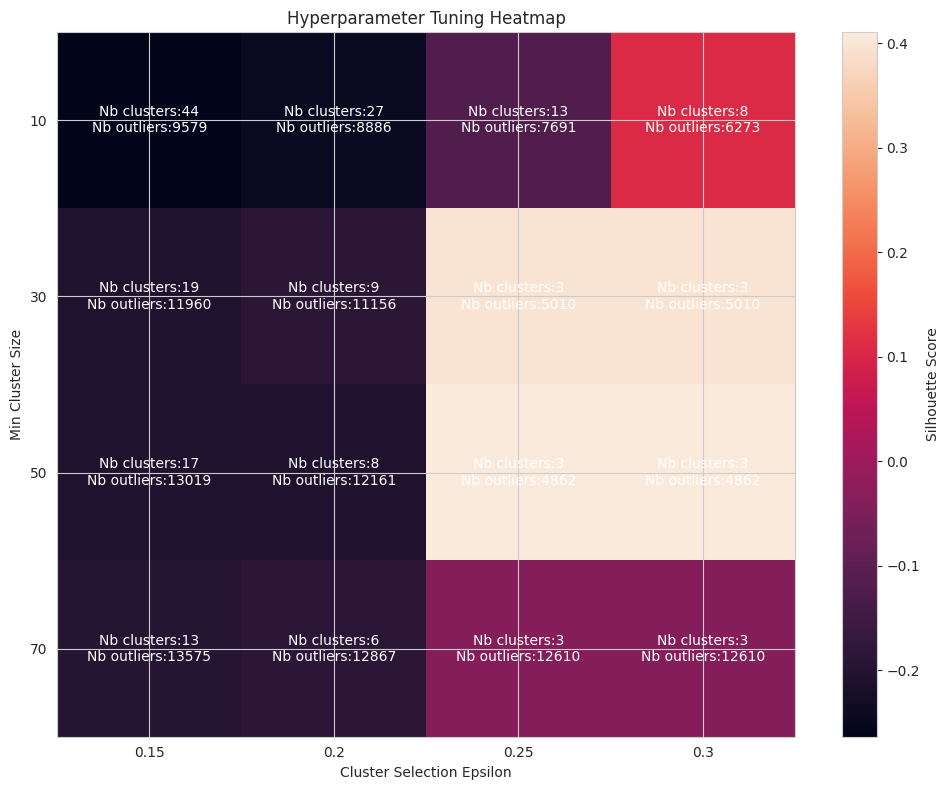

In [296]:
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

Model fitted. Num of clusters found: 2
Labels and probabilities added


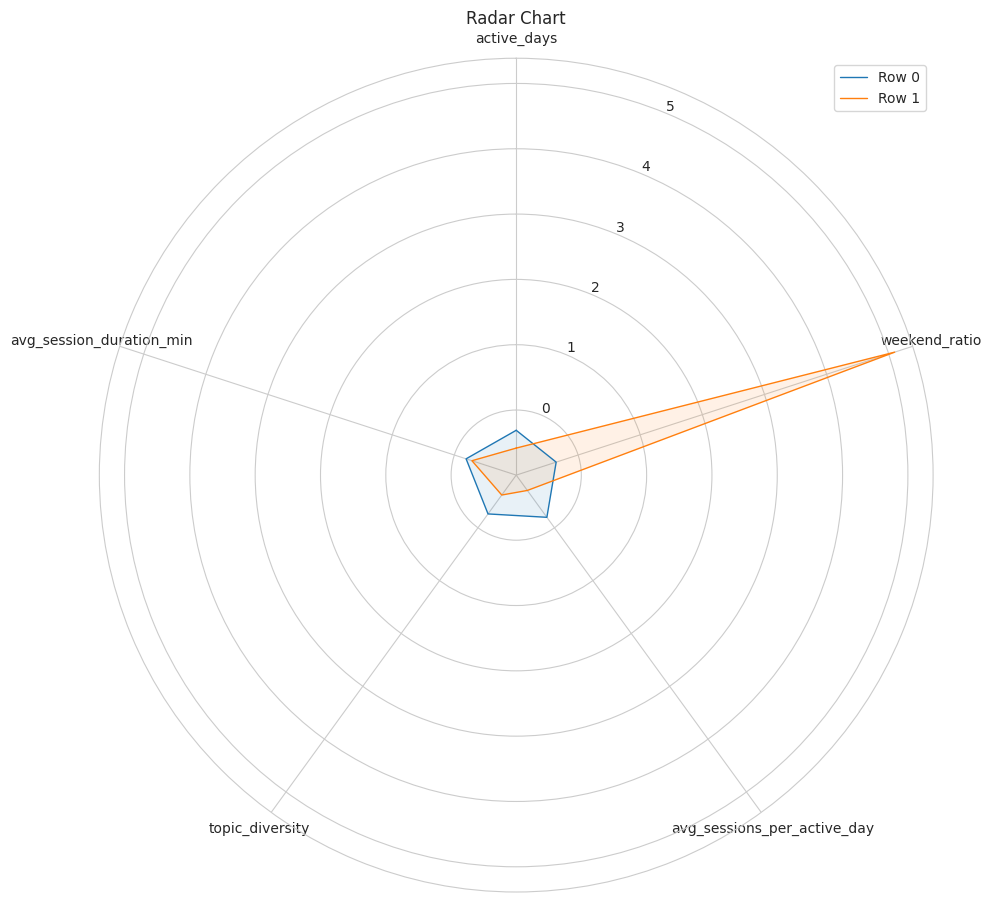

In [297]:
custom_features_clusters3, custom_features_clusters5_centroids = init_fit_hdbscan_clustering(X_custom, min_cluster_size=50, cluster_selection_epsilon=0.25)
create_radar_chart(custom_features_clusters5_centroids)

In [299]:
custom_features_clusters3['labels'].value_counts()

labels
 0    14017
-1     4862
 1       66
Name: count, dtype: int64

#### Analysis
Unfortunately, the same problem occurred. We cannot say anything about our hypothesis since there are way too many outliers and a cluster on 66 people is really not representative.

## Gaussian mixture model

HDBSCAN gave some results. Even if some of the clusters made sense, the results were not really meaningful. Hence, we decided to use another method: Gaussian mixture model. GMM is an upgraded version of kNN, hence there can not be any outliers and the number of clusters are defined by ourselves.

### For entire dataset

n_comp: 2, score: 0.44569709359912446
n_comp: 3, score: 0.11450267328332524
n_comp: 4, score: 0.050709251698302274
n_comp: 5, score: 0.1157822561022175
n_comp: 6, score: 0.07996289136421349
n_comp: 7, score: 0.05839620862632215
n_comp: 8, score: 0.13021213906744422
n_comp: 9, score: 0.08924978390711136


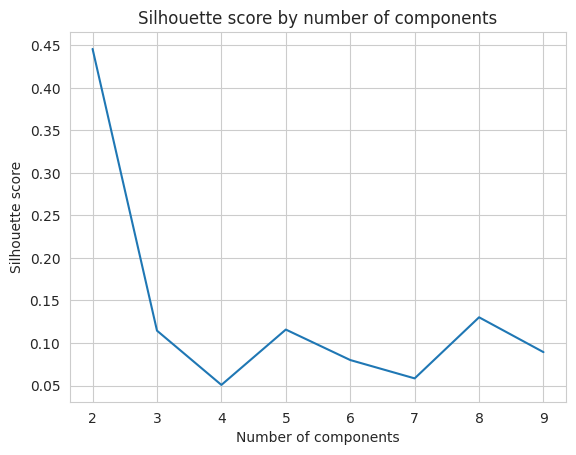

In [305]:
# Let's directly do a grid search on the best number of clusters in function of the silhouette score
grid_search_GMM(X_scaled_final_clustering, range(2,10))

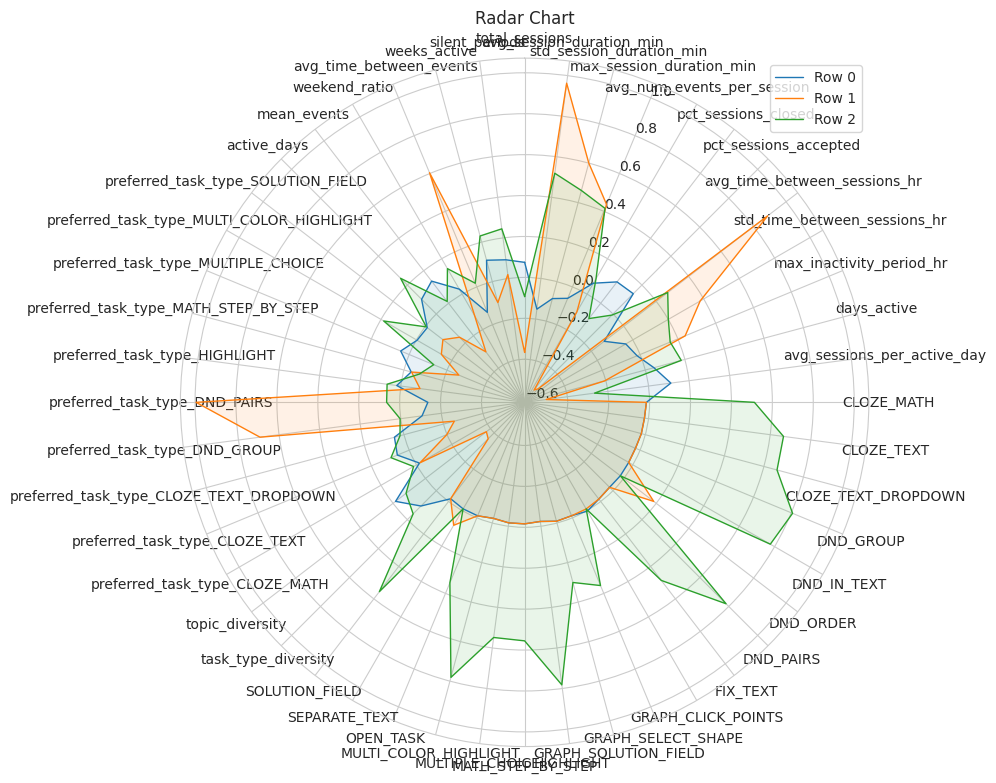

       0
0  16118
1   2202
2    625


In [311]:
# We can fit the model with a good number of clusters, plot it and show the number of samples per cluster
fit_and_plot_GMM(X_scaled_final_clustering, 3)

#### Analysis
We can already see an improvement on the number of samples per cluster. For a dataset that suffers a lot from the curse of dimensionality and the binary features, this is not bad at all. We can see that a non negligible number of people are in the cluster 1. This persona is globally explained by people prefering the task type DND_PAIRS and DND_GROUP, having a low topic and task type diversity and those people also have a high average session duration and average time between session, but a low overall number of sessions.
This is a big improvement from HDBSCAN.

### For session features
In order to fix the curse of dimensionality and binary features problems, let's try GMM with the session features.

n_comp: 2, score: 0.06229657772083433
n_comp: 3, score: 0.22158328976428485
n_comp: 4, score: 0.09165749213106726
n_comp: 5, score: 0.05752198782400487
n_comp: 6, score: 0.055238111426295346
n_comp: 7, score: 0.005589935417924019
n_comp: 8, score: 0.021102093965870896
n_comp: 9, score: 0.03559764554649334


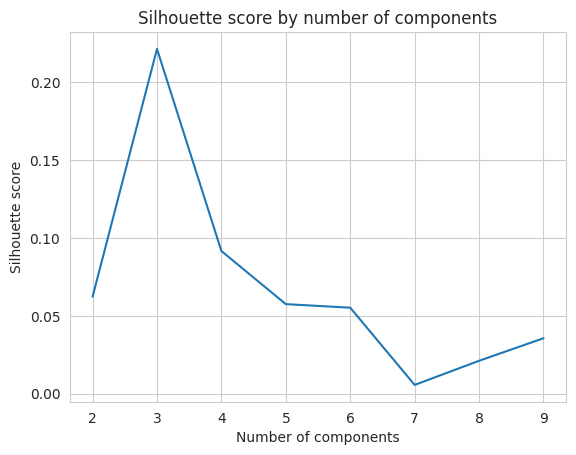

In [312]:
grid_search_GMM(session_scaled_df, range(2,10))

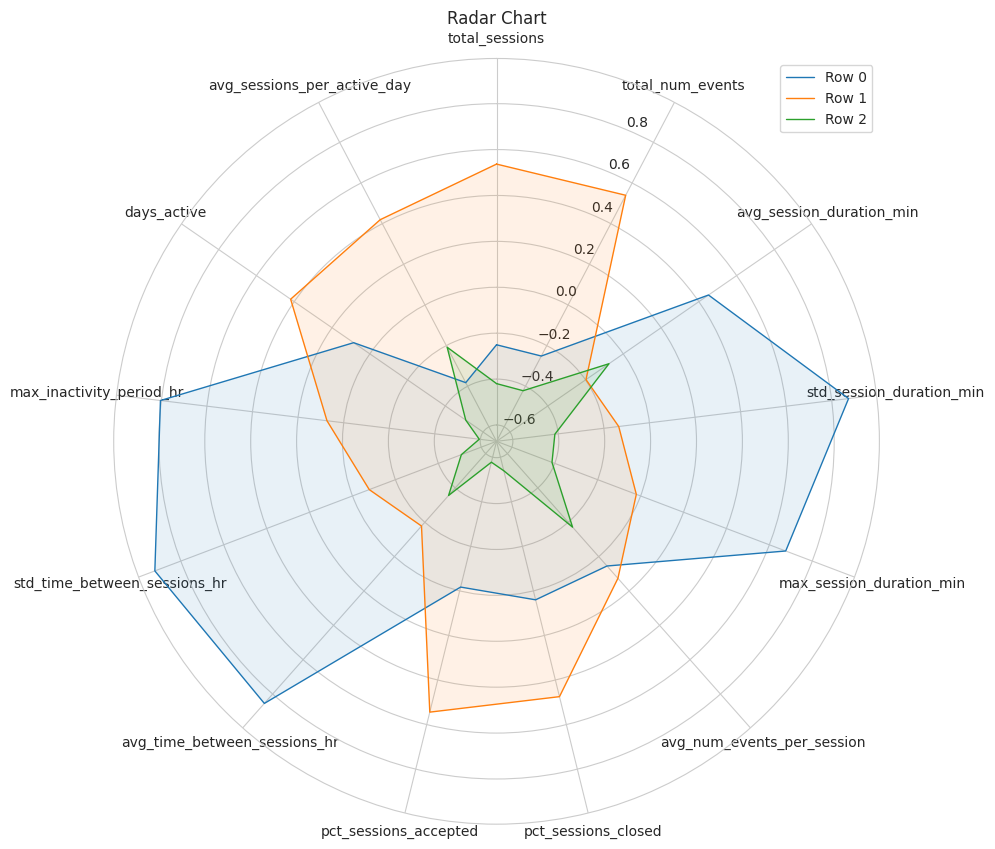

      0
0  4587
1  7835
2  7208


In [315]:
fit_and_plot_GMM(session_scaled_df, 3)

#### Analysis
We finally have a meaningful clustering. Three personas have been extracted by GMM:
- First persona: The people in this persona generally have low values for the average time between sessions or average sessions duration. However, they have high values in term of total sessions or average sessions per active day as well as the percentage of session accepted of closed. This persona represents the people doing a lot of sessions.
- Second persona: The people in this persona generally have low values for the number of sessions or average sessions per active days. However, they have high values in term of biggest inactivity period or time between sessions as well as the average session duration. This persona represents the people not doing a lot of sessions but long ones when they do.
- Third persona: The people in this persona generally have low values in the set. They have a low percentage of accepted or closed sessions, a low total number of events or sessions, etc... This persona represents the people not being very active.
This represents a big step. However, let's keep in mind that we have a silhouette score of 0.22 which is not a really good one but stays acceptable.

### With PCA
It is time to try GMM with PCA in order to cluster the dataset on the principal components.

In [316]:
# We declare and fit the PCA on the dataset
pca10 = PCA(n_components=10)
pca10_result = pca10.fit_transform(X_scaled_final_clustering)
pca10_result_df = pd.DataFrame(pca10_result.T, [f'PC{i+1}' for i in np.arange(10)]).T
pca10_result_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      17.568662 -1.824967 -8.680287 -0.682837 -1.184169  1.421992  0.614106   
1      14.501802 -0.166477 -4.798516  0.225689  0.076235 -0.158278 -0.304795   
2      14.805308 -1.034737 -7.546736  1.737444 -3.520687  0.009792  0.818418   
3      -1.039562  0.482279 -0.982466  0.452156 -0.548276  0.720506  0.041815   
4       0.163818 -0.654556 -0.606964  1.097269 -1.054265 -0.624328  0.267846   
...          ...       ...       ...       ...       ...       ...       ...   
18940  -2.476876 -0.391080 -0.548346  1.886486  0.455417 -0.345201  0.084764   
18941  -2.661090 -0.142660 -0.648177  1.703650 -0.109329 -0.324927  0.180963   
18942  -2.089892 -0.459577  0.777041  1.361716 -0.247390 -0.615790  0.151353   
18943  -2.791724 -0.095016 -1.227376  1.937521  0.224895 -0.209639  0.131643   
18944  -2.414766 -0.494390 -0.147066 -0.096036  0.050186  0.175823 -0.147894   

            PC8       PC9      PC10  
0     -1.981917  0.983598 -0.833872  
1     -0.833062 -0.164106 -0.894622  
2     -1.900927  1.153319 -0.758968  
3     -0.216349 -0.284405  0.206465  
4     -0.777494  0.637928 -0.275416  
...         ...       ...       ...  
18940  0.156615 -0.247906  0.043861  
18941 -0.172676  0.023718 -0.069213  
18942 -0.383098  0.315835 -0.054145  
18943  0.062358 -0.233582 -0.007552  
18944 -0.403996 -0.079311  0.256441  

[18945 rows x 10 columns]

n_comp: 2, score: 0.36311776277407065
n_comp: 3, score: 0.3481164459583611
n_comp: 4, score: 0.0034601062303559896
n_comp: 5, score: 0.05569769317191982
n_comp: 6, score: 0.015634691234653546
n_comp: 7, score: 0.047959157347258904
n_comp: 8, score: 0.0731925890959105
n_comp: 9, score: 0.03581994122405841


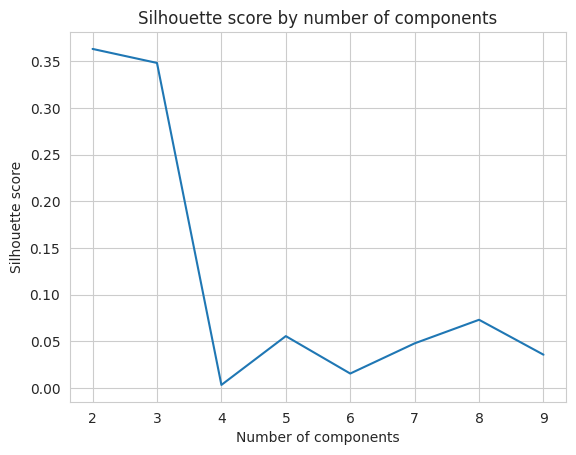

In [317]:
# Perform a grid search
grid_search_GMM(pca10_result_df, range(2,10))

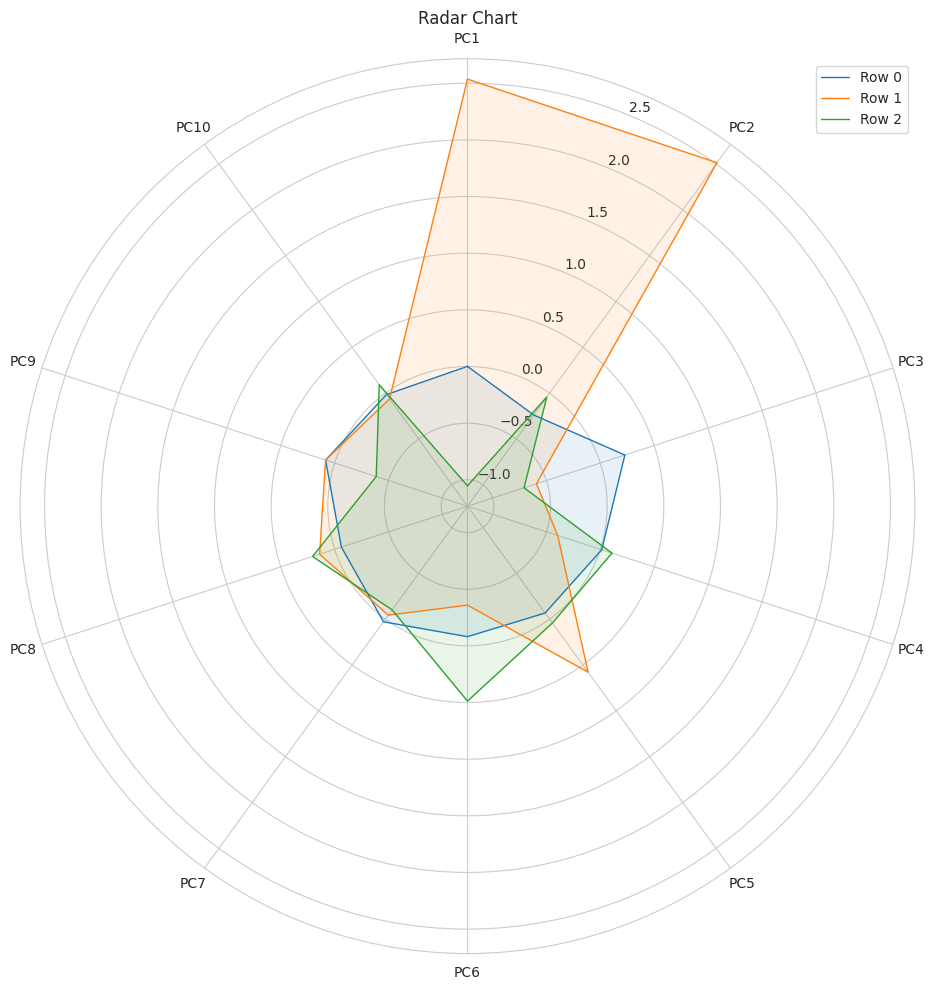

       0
0  14165
1   1392
2   3388


In [320]:
# Plot the centroids
fit_and_plot_GMM(pca10_result_df, 3)

Here are the biggest weigths of the principal components:
- PC1: most represented by weeks_active, active_days, mean_events, days_active and silent_periods
- PC2: most represented by std_session_duration_min, std_time_between_sessions_hr, max_session_duration_min, avg_time_between_sessions_hr, max_inactivity_period_hr and avg_session_duration_min
- PC3: most represented by pct_sessions_accepted, pct_sessions_closed and avg_sessions_per_active_day
- PC6: most represented by preferred_task_type_CLOZE_TEXT_DROPDOWN

Unfortunately, we still have a 'main cluster' which groups a lot of samples. However, we can see some patterns in the others:
- The first persona represents the people having high active days or weeks and high time between sessions or session duration. They are doing long sessions from a long time
- The second persona represents the people having low active days or weeks as well as a low percentage of sessions accepted and average number of sessions per active days. They are apparently not very active.


### For custom features
Remember our previous hypothesis: 'People working during the weekend tends to be hard workers, hence have more active days and spend more time on a session.' We will now try again to validate or reject it by clustering those features with GMM.

n_comp: 2, score: 0.24737402961398813
n_comp: 3, score: 0.09386574129055104
n_comp: 4, score: 0.2117295633265484
n_comp: 5, score: 0.1826068115194791
n_comp: 6, score: 0.04165449304953477
n_comp: 7, score: 0.026512482465496066
n_comp: 8, score: 0.043522883291664885
n_comp: 9, score: 0.011313557352090699


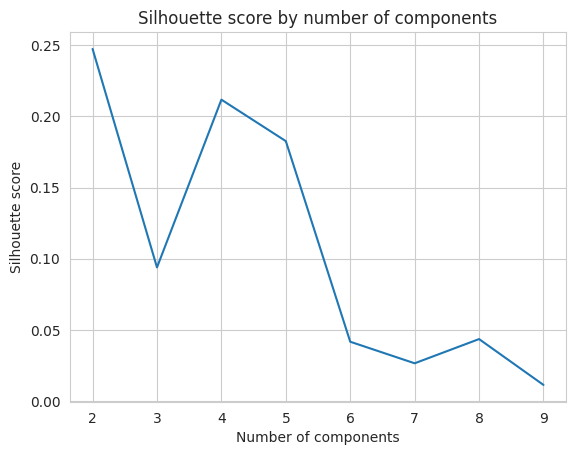

In [321]:
grid_search_GMM(X_custom, range(2,10))

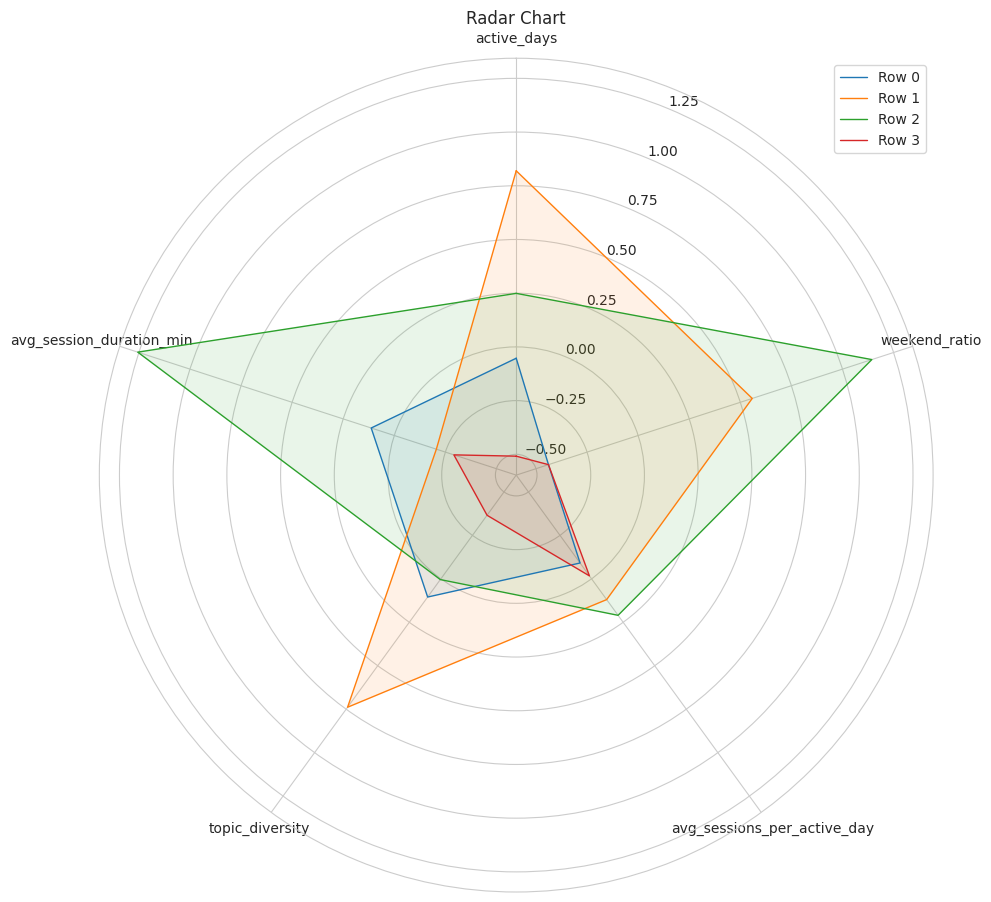

      0
0  4983
1  5612
2  1842
3  6508


In [322]:
fit_and_plot_GMM(X_custom, 4)

#### Analysis
We first see that the samples are well distributed whitin the cluster. A silhouette score of 0.21 is really not crazy but is still acceptable. Let's first describe all the personas we found:
- Persona 1: People in this persona have overall some quite standard values, except for the weekend ratio. They are most likely standard students wanting to rest during the weekend.
- Persona 2: People in this persona have some high values. They have a lot of active days, relatively high weekend ratio and topic diversity. However, they have a low average session duration. This persona could represent studious students doing a lot of short sessions on many topics, even during the weekend.
- Persona 3: This is the smallest one but also the most interesting. In this persona, people have a very high weekend ratio and average session duration. They also have a lot of active days and average number of sessions per active days. They are most likely studious students studying with big sessions even on the weekends.
- Persona 4: This is the biggest persona. In this persona, values are relatively low. Low weekend ratio, active days, average session duration and topic diversity. The average sessions number per active day is the only value in the mean. They are most likely the students that do not engaged much in the platform..

Hence, we can conclude that the hypothesis is not completely true. People working on weekends tends indeed to have more active days than the others. However, the persona 2, containing a lot of people, have a high weekend ratio but a low average session duration. People in this persona tends to work on the weekend but do a lot of short sessions.

## Task 3: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

Most of the feature engineering was done by Lina, while
the model selection, fitting and analysing were done by Benjamin and Thibaut.